In [17]:


import math
import random
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim

from ortools.constraint_solver import pywrapcp, routing_enums_pb2


In [18]:

# =========================
# Global knobs (easy tuning)
# =========================
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# City / motion
R = 5.5                 # half "L1 radius" of diamond region; feasible points satisfy |x|+|y| <= R
V = 0.19                  # speed (distance units per minute)
DT = 0.5                 # minutes per step
HORIZON_MIN = 5760.0      # episode length in minutes (e.g., 96 hours)
STEPS_PER_EP = int(HORIZON_MIN / DT)
# terminal state: all packages delivered


# Demand & revenue
LAMBDA = 0.60            # ride arrival rate per minute (Poisson, spatially uniform over region)
R_PICK_ALPHA = 0.5      # pickup visibility radius parameter r = alpha * R / sqrt(2) (L1-constraint approx)
RT = 5.5                 # per-distance revenue for rides
RP = 2                 # revenue per delivered package
REWARD_SCALE = 1.0/8.0
INV_REWARD_SCALE = 1.0/REWARD_SCALE
REPORT_UNSCALED = True
GAMMA_PACK = 0.075        # package spatial intensity (packages per unit area); area = 2*R^2 for diamond in L1 model
RIDE_TTL_MINUTES = 5    # ride request time to live in minutes

# DRL obs/action shaping
MAX_VISIBLE_RIDES = 5    # keep top-K closest pickups
K_NEAREST_PACK = 10      # encode nearest K packages
DISCOUNT = 0.99
PPO_STEPS = 8192
PPO_MINI_BATCH = 256
PPO_EPOCHS = 4
CLIP_EPS = 0.2
VF_COEF = 0.5
ENT_COEF = 0.02
LR = 3e-4
UPDATES = 200
GAE_LAMBDA = 0.95

# Heuristic
SWITCH_GRACE_STEPS = 6
HEUR_SOFT_PICK_CAP = None


EVAL_EPISODES = 5        # evaluation batch after each update

rng = np.random.default_rng(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# <<< MOD-SEED: per-combo deterministic seeds
def set_global_seeds(seed: int):
    """Reset all RNGs so each combo is reproducible & training path mimics main()."""
    global rng
    rng = np.random.default_rng(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)




In [19]:
# =========================
# Non-stationary demand fit from Uber NYC data
# =========================
from pathlib import Path
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

UBER_PARQUET_DIR = Path('/Users/alfredzhong/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/GeorgiaTech/Research/Uber_NYC')
HOURLY_ALPHA_CACHE = UBER_PARQUET_DIR / 'hourly_alpha_2021.csv'

def fit_hourly_alpha_from_parquet(parquet_dir: Path, cache_path: Path = HOURLY_ALPHA_CACHE) -> np.ndarray:
    # Compute alpha(t): average hourly trip ratio across days, with caching.
    if cache_path.exists():
        cached = pd.read_csv(cache_path)
        alpha = np.zeros(24, dtype=float)
        alpha[cached['hour'].to_numpy(dtype=int)] = cached['alpha'].to_numpy(dtype=float)
        return alpha

    files = sorted(parquet_dir.glob('fhvhv_tripdata_2021-*.parquet'))
    if not files:
        raise FileNotFoundError(f'No parquet files found under {parquet_dir}')

    ratio_sum = np.zeros(24, dtype=float)
    day_count = 0

    for fp in files:
        # Read only pickup time to keep memory manageable
        s = pd.read_parquet(fp, columns=['pickup_datetime'], engine='pyarrow')['pickup_datetime'].dropna()
        day = s.dt.date
        hour = s.dt.hour
        counts = pd.DataFrame({'day': day, 'hour': hour}).value_counts().rename('cnt').reset_index()
        totals = counts.groupby('day')['cnt'].sum().rename('tot')
        counts = counts.join(totals, on='day')
        counts['ratio'] = counts['cnt'] / counts['tot']

        ratio_by_hour = counts.groupby('hour')['ratio'].sum()
        for h, val in ratio_by_hour.items():
            ratio_sum[int(h)] += float(val)
        day_count += totals.shape[0]

    alpha = ratio_sum / max(day_count, 1)

    out = pd.DataFrame({'hour': np.arange(24, dtype=int), 'alpha': alpha})
    out.to_csv(cache_path, index=False)
    return alpha

# alpha(t): hourly trip share; alpha_mean = 1/24 as requested
HOURLY_ALPHA = fit_hourly_alpha_from_parquet(UBER_PARQUET_DIR)
HOURLY_ALPHA_MEAN = 1.0 / 24.0
HOURLY_MULTIPLIER = HOURLY_ALPHA / HOURLY_ALPHA_MEAN  # equals 24 * alpha(t)

print('Hourly alpha(t) loaded. Sum(alpha) =', HOURLY_ALPHA.sum())
print(pd.DataFrame({'hour': np.arange(24), 'alpha': HOURLY_ALPHA, 'multiplier': HOURLY_MULTIPLIER}).head())


Hourly alpha(t) loaded. Sum(alpha) = 0.9999999999999989
   hour     alpha  multiplier
0     0  0.035802    0.859255
1     1  0.025243    0.605838
2     2  0.017986    0.431670
3     3  0.013526    0.324612
4     4  0.012458    0.298984


In [20]:

# ==============
# Util functions
# ==============
def manhattan(a: np.ndarray, b: np.ndarray) -> float:
    return float(abs(a[0]-b[0]) + abs(a[1]-b[1]))

def l1_inside(x: float, y: float, r: float) -> bool:
    return abs(x) + abs(y) <= r

"""
def sample_uniform_point_in_diamond(R: float) -> np.ndarray:
    # Rejection sampling in square [-R, R]^2 with L1 constraint
    while True:
        x = rng.uniform(-R, R)
        y = rng.uniform(-R, R)
        if abs(x) + abs(y) <= R:
            return np.array([x, y], dtype=np.float32)
"""
# Normally, it won't go out of the diamond-shaped range. For robustness, 
# if it goes out due to numerical errors at the boundary, it needs to be projected back to the nearest boundary.
def project_to_diamond(p: np.ndarray, R: float) -> np.ndarray:
    # If |x|+|y|>R, project to boundary along direction to origin
    s = abs(p[0]) + abs(p[1])
    if s <= R:
        return p
    if s == 0:
        return np.array([0.0, 0.0], dtype=np.float32)
    return p * (R / s)

def step_towards(from_pt: np.ndarray, to_pt: np.ndarray, max_dist: float) -> Tuple[np.ndarray, float, bool]:
    """Move along Manhattan shortest path: first x, then y (or vice versa); return (new_pos, traveled, reached)"""
    x0, y0 = from_pt
    x1, y1 = to_pt
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    d = dx + dy
    if d <= max_dist:
        return to_pt.copy(), d, True
    # Move along x first
    move_x = min(dx, max_dist)
    sign_x = np.sign(x1 - x0)
    x_new = x0 + sign_x * move_x
    remaining = max_dist - move_x
    if remaining > 1e-8:
        move_y = min(dy, remaining)
        sign_y = np.sign(y1 - y0)
        y_new = y0 + sign_y * move_y
    else:
        y_new = y0
    p = np.array([x_new, y_new], dtype=np.float32)
    return p, max_dist, False



In [21]:

# ========================
# Environment (no zoning)
# ========================
@dataclass
class RideReq:
    pickup: np.ndarray
    dropoff: np.ndarray
    trip_len: float

class CoModalEnv:
    """
    - Region: diamond |x|+|y| <= R (L1 metric)
    - Packages: spatial Poisson with intensity gamma; N ~ Poisson(gamma * R^2), positions IID uniform in diamond
    - Ride arrivals: Poisson(lambda(t) * DT) with lambda(t)=LAMBDA*alpha(t)/alpha_mean and spatial uniformity
    - Vehicle:
        * cannot deliver packages while carrying passenger (pickup->dropoff)
        * revenue: RP per delivered package; RT * (distance with passenger)
    - Action (discrete): 0 = continue delivering package; i=1..MAX_VISIBLE_RIDES = accept ith visible ride (if available)
      When busy enroute to pickup/dropoff, action is ignored (auto-continue).
    - Observation: vector with normalized features:
        * pos (x/R, y/R), time_frac, flags (to_pickup, with_pass)
        * K nearest packages: for each, (dx/R, dy/R, l1/R)
        * up to K rides visible: for each, (dx_pick/R, dy_pick/R, l1_pick/R, dx_drop/R, dy_drop/R, l1_trip/R)
        * counts: remaining_pkg / (1 + E[N]), current_visible / MAX_VISIBLE_RIDES
      Invalid slots are zero-padded. We also return an action mask for invalid ride indices.
    """
    def __init__(self,
                 R: float = R,
                 v: float = V,
                 dt: float = DT,
                 lam: float = LAMBDA,
                 gamma_pack: float = GAMMA_PACK,
                 rp: float = RP,
                 rt: float = RT,
                 r_pick_alpha: float = R_PICK_ALPHA,
                 ride_ttl_minutes: float=RIDE_TTL_MINUTES, #ride request time to live in minutes
                 max_visible: int = MAX_VISIBLE_RIDES,
                 hourly_multiplier: np.ndarray = HOURLY_MULTIPLIER): 
                 
        self.R = R
        self.v = v
        self.dt = dt
        self.lam = lam
        # Non-stationary arrival rate profile derived from Uber NYC data
        self.hourly_multiplier = np.asarray(hourly_multiplier, dtype=float)
        if self.hourly_multiplier.shape[0] != 24:
            raise ValueError('hourly_multiplier must have length 24')
        self.gamma = gamma_pack
        self.rp = rp * REWARD_SCALE
        self.rt = rt * REWARD_SCALE
        # max pickup radius (L1) following r = alpha * R / sqrt(2); we keep L1 constraint
        self.r_pick = r_pick_alpha * R / math.sqrt(2.0)
        
        self.rng = np.random.default_rng()

        self.max_visible = int(max_visible)
        self.k_pack = K_NEAREST_PACK
        self.ride_ttl_steps = max(1, int(round(ride_ttl_minutes / self.dt)))
        self._ended_reason: Optional[str] = None
        
        self.reset()

    def reset(self, seed: Optional[int] = None):
        if seed is not None:
            self.rng = np.random.default_rng(int(seed))
        # sample packages (these are Voronoi seeds and also delivery points)
        area = 2*(self.R ** 2)
        n_pkg = self.rng.poisson(self.gamma * area)
        n_pkg = max(1, int(n_pkg))
        pkg_list = [self._sample_uniform_point_in_diamond(self.R) for _ in range(n_pkg)]
        self.pkg_pos_all = np.asarray(pkg_list, dtype=np.float32)   # [N,2] fixed seeds for this episode
        self.pkg_delivered = np.zeros(n_pkg, dtype=bool)            # delivered flag for each seed
        self.pkg_remaining_idx = list(range(n_pkg))                 # indices of remaining seeds

        # a view for convenience in obs/_nearest_package:
        self.packages = self.pkg_pos_all[self.pkg_remaining_idx]

        # vehicle state
        self.pos = np.array([0.0, 0.0], dtype=np.float32)
        self.t = 0.0
        self.ride_buffer: List[Tuple[RideReq, int]] = []
        self.to_pickup: Optional[np.ndarray] = None
        self.with_passenger: bool = False
        self.drop_target: Optional[np.ndarray] = None

        self.revenue_cum = 0.0
        self._steps = 0
        self._ended_reason = None
        self.accepted_rides = 0
        
        self.time_rides_min = 0.0
        self.time_delivery_min = 0.0

        obs, mask = self._get_obs()
        return obs, mask

    def _append_new_ride(self, reqs: List[RideReq]):
        """Bring the new ride request to this buffer."""
        if not reqs:
            return
        ttl0 = self.ride_ttl_steps
        self.ride_buffer.extend([(r, ttl0) for r in reqs])
    
    def _sample_uniform_point_in_diamond(self, R: float) -> np.ndarray:
        # Rejection sampling in square [-R, R]^2 with L1 constraint
        while True:
            x = self.rng.uniform(-R, R)
            y = self.rng.uniform(-R, R)
            if abs(x) + abs(y) <= R:
                return np.array([x, y], dtype=np.float32)
    
    def _sample_rides_this_step(self) -> List[RideReq]:
        # Scale lambda by hour-of-day using alpha(t)/alpha_mean as requested
        hour_of_day = int((self.t % 1440.0) // 60.0)
        lam_eff = self.lam * self.hourly_multiplier[hour_of_day]
        k = self.rng.poisson(lam_eff * self.dt)
        reqs = []
        for _ in range(int(k)):
            pk = self._sample_uniform_point_in_diamond(self.R)
            dp = self._sample_uniform_point_in_diamond(self.R)
            reqs.append(RideReq(pk, dp, manhattan(pk, dp)))
        return reqs

    def _visible_rides(self) -> List[RideReq]:
        # only show rides with pickup within r_pick (L1) AND we can reach pickup before TTL expires
        visible = []
        for (r, ttl) in self.ride_buffer:
            if ttl <= 0:
                continue
            # 1) Distance filtering: pickup must be within the visible radius
            if manhattan(self.pos, r.pickup) > self.r_pick:
                continue
            # 2) TTL + ETA filtering: must be able to reach pickup within the remaining TTL
            eta_min = manhattan(self.pos, r.pickup) / self.v
            if eta_min <= ttl * self.dt: 
                visible.append(r)
        # Sort by pickup distance and truncate
        visible.sort(key=lambda rr: manhattan(self.pos, rr.pickup))
        return visible[:self.max_visible]


    def _nearest_package(self) -> Optional[np.ndarray]:
        if len(self.packages) == 0:
            return None
        dists = np.abs(self.packages - self.pos).sum(axis=1)
        idx = int(np.argmin(dists))
        return self.packages[idx].copy()


    def _deliver_if_arrived(self):
        """Deliver any packages exactly at current location; update delivered flags & remaining set."""
        if len(self.pkg_remaining_idx) == 0:
            return 0
        # distances to remaining only
        rem_pos = self.pkg_pos_all[self.pkg_remaining_idx]  # [M,2]
        dists = np.abs(rem_pos - self.pos).sum(axis=1)
        hit_local = np.where(dists < 1e-6)[0]               # local indices in 'remaining view'
        delivered = int(len(hit_local))
        if delivered > 0:
            # map local -> global seed idx, mark delivered, and remove from remaining
            for k in sorted(hit_local, reverse=True):
                gidx = self.pkg_remaining_idx[k]
                self.pkg_delivered[gidx] = True
                self.pkg_remaining_idx.pop(k)
            # refresh convenience view
            self.packages = self.pkg_pos_all[self.pkg_remaining_idx]
            # reward
            self.revenue_cum += self.rp * delivered
        return delivered

    # ---- L1-Voronoi helpers ----
    def voronoi_owner_idx(self, pt: np.ndarray) -> int:
        """Return argmin_j L1(pt, pkg_pos_all[j]) (global seed index)."""
        dif = np.abs(self.pkg_pos_all - pt[None, :]).sum(axis=1)   # [N]
        return int(np.argmin(dif))

    def dropoff_allowed(self, drop: np.ndarray) -> bool:
        """Disallow if drop falls into Voronoi cell of an already delivered package."""
        owner = self.voronoi_owner_idx(drop)
        return not bool(self.pkg_delivered[owner])

    def _get_obs(self) -> Tuple[np.ndarray, np.ndarray]:
        # Visible rides & nearest packages
        visible = self._visible_rides()
        # Packages features
        pack_feats = []
        if len(self.packages) > 0:
            d = np.abs(self.packages - self.pos).sum(axis=1)
            order = np.argsort(d)[:self.k_pack]
            for j in order:
                rel = (self.packages[j] - self.pos) / self.R
                pack_feats.extend([rel[0], rel[1], d[j] / self.R])
        # pad
        while len(pack_feats) < 3 * self.k_pack:
            pack_feats.append(0.0)

        ride_feats = []
        for r in visible:
            relp = (r.pickup - self.pos) / self.R
            reld = (r.dropoff - self.pos) / self.R
            ride_feats.extend([relp[0], relp[1], manhattan(self.pos, r.pickup) / self.R,
                               reld[0], reld[1], r.trip_len / self.R])
        while len(ride_feats) < 6 * self.max_visible:
            ride_feats.append(0.0)

        time_frac = self.t / HORIZON_MIN
        flags = [1.0 if self.to_pickup is not None else 0.0,
                 1.0 if self.with_passenger else 0.0]

        counts = [len(self.packages) / (1.0 + self.gamma * (2*self.R ** 2)),
                  len(visible) / float(self.max_visible)]

        core = [self.pos[0] / self.R, self.pos[1] / self.R, time_frac] + flags + counts
        obs = np.array(core + pack_feats + ride_feats, dtype=np.float32)

        # Action mask: 0 always valid; i>0 valid if i<=len(visible)
        mask = np.zeros(1 + self.max_visible, dtype=np.float32)
        mask[0] = 1.0
        for i in range(len(visible)):
            mask[1 + i] = 1.0
        return obs, mask

    def step(self, action: int):
        reward = 0.0
        done = False
        delivered_step = 0 # track how many packages delivered in this step

        # --- At the beginning of CoModalEnv.step(self, action), determine the attribution of this step ---


        
        # add fresh arrivals
        self._append_new_ride(self._sample_rides_this_step())

        # If busy towards pickup or with passenger, ignore action (auto-continue)
        if self.to_pickup is not None:
            # move towards pickup
            new_pos, d, reached = step_towards(self.pos, self.to_pickup, self.v * self.dt)
            self.pos = project_to_diamond(new_pos, self.R)
            if reached:
                self.to_pickup = None
                self.with_passenger = True
            # cannot deliver while enroute to pickup
        elif self.with_passenger:
            # move towards dropoff; accrue ride revenue per distance traveled
            new_pos, d, reached = step_towards(self.pos, self.drop_target, self.v * self.dt)
            self.pos = project_to_diamond(new_pos, self.R)
            reward += self.rt * d    # ride distance revenue in this step
            self.revenue_cum += self.rt * d
            if reached:
                self.with_passenger = False
                self.drop_target = None
        else:
            # free: can choose to deliver or accept a visible ride
            visible = self._visible_rides()
            if action > 0 and action <= len(visible):
                chosen = visible[action - 1]
                # remove chosen from buffer
                # (remove by identity)
                for i, (r, ttl) in enumerate(self.ride_buffer):
                    if r is chosen:
                        self.ride_buffer.pop(i)
                        break
                # set pickup/drop targets
                self.to_pickup = chosen.pickup.copy()
                self.drop_target = chosen.dropoff.copy()
                self.accepted_rides += 1
                # move towards pickup immediately this step
                new_pos, d, reached = step_towards(self.pos, self.to_pickup, self.v * self.dt)
                self.pos = project_to_diamond(new_pos, self.R)
                if reached:
                    self.to_pickup = None
                    self.with_passenger = True
            else:
                # deliver: go to nearest package (if any)
                target = self._nearest_package()
                if target is not None:
                    new_pos, d, reached = step_towards(self.pos, target, self.v * self.dt)
                    self.pos = project_to_diamond(new_pos, self.R)
                    if reached:
                        delivered = self._deliver_if_arrived()
                        delivered_step += delivered
                        reward += self.rp * delivered
                # else idle at current location

        # small clean-up: remove stale rides outside pickup radius (we keep buffer but they vanish after 1 step) and TTL Decay
        # simple model: unaccepted rides expire by end of step
        if self.ride_buffer:
            new_buf = []
            for (r, ttl) in self.ride_buffer:
                ttl -= 1
                if ttl > 0:
                    new_buf.append((r, ttl))
            self.ride_buffer = new_buf

        self.t += self.dt
        self._steps += 1

        # Deliver any packages exactly at position (numerical safety)
        if self.to_pickup is None and not self.with_passenger:
            delivered = self._deliver_if_arrived()
            if delivered > 0:
                delivered_step += delivered
                reward += self.rp * delivered
        
        #make sure the time is recorded correctly, aka is_ride_phase is computed after the action is taken
        is_ride_phase = (self.to_pickup is not None) or self.with_passenger
        if is_ride_phase:
            self.time_rides_min += self.dt
        else:
            self.time_delivery_min += self.dt
        
        # ---------- termination checks & terminal info ----------
        done_horizon = (self.t >= HORIZON_MIN)
        done_packages = (len(self.packages) == 0) and (not self.with_passenger) and (self.to_pickup is None)
        
        if done_packages or done_horizon:
            done = True
            self._ended_reason = "packages_done" if done_packages else "horizon_reached"
        
        info: Dict[str, object] = {}
        if done:
            info["terminal_time_min"] = float(self.t)
            info["ended_reason"] = self._ended_reason
            info["accepted_rides"] = int(self.accepted_rides)
            info["time_rides_min"] = float(self.time_rides_min)
            info["time_delivery_min"] = float(self.time_delivery_min)

        info["delivered_step"] = int(delivered_step)
        
        obs, mask = self._get_obs()
        return obs, reward, done, info, mask

    @property
    def obs_dim(self):
        # core (3 + 2 flags + 2 counts) + 3*K + 6*MAX_VISIBLE
        return (3 + 2 + 2) + 3 * self.k_pack + 6 * self.max_visible

    @property
    def act_dim(self):
        return 1 + self.max_visible




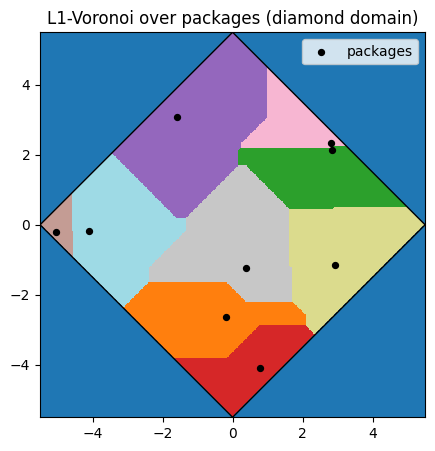

In [22]:
def plot_l1_voronoi_for_env(env: CoModalEnv, res: int = 200, show_delivered: bool = True):
    """
    Approximates and plots the L1-Voronoi diagram for the given seeds (env.pkg_pos_all),
    clipped to a diamond-shaped region defined by |x|+|y|<=R.
    - res: The resolution of the grid (number of pixels per side).
    """
    R = env.R
    # Generate grid
    xs = np.linspace(-R, R, res)
    ys = np.linspace(-R, R, res)
    XX, YY = np.meshgrid(xs, ys)
    mask = (np.abs(XX) + np.abs(YY) <= R)           # Points within the diamond
    Xflat = XX[mask]; Yflat = YY[mask]
    P = np.stack([Xflat, Yflat], axis=1)            # [M,2]

    # For each grid point, find the nearest seed (L1 distance)
    seeds = env.pkg_pos_all                         # [N,2]
    # A direct O(MN) approach is sufficient; for large N, consider KDTree(metric='manhattan')
    owner = np.argmin(np.abs(P[:,None,:] - seeds[None,:,:]).sum(axis=2), axis=1)  # [M]

    # Fill the owner indices back into the image
    img = -np.ones_like(XX, dtype=int)
    img[mask] = owner

    # Plotting
    plt.figure(figsize=(5,5))
    plt.imshow(img, origin="lower",
               extent=[-R, R, -R, R], interpolation="nearest", cmap="tab20")
    # Draw the diamond boundary
    bx = np.array([-R, 0, R, 0, -R]); by = np.array([0, R, 0, -R, 0])
    plt.plot(bx, by, "k-", lw=1.0)
    # Draw the seed points
    plt.scatter(seeds[:,0], seeds[:,1], s=18, c="k", marker="o", label="packages")
    if show_delivered and hasattr(env, "pkg_delivered"):
        dmask = env.pkg_delivered
        if dmask.any():
            plt.scatter(seeds[dmask,0], seeds[dmask,1], s=30, facecolors="none", edgecolors="w", linewidths=1.5, label="delivered")
    plt.title("L1-Voronoi over packages (diamond domain)")
    plt.xlim([-R, R]); plt.ylim([-R, R]); plt.gca().set_aspect("equal", adjustable="box")
    plt.legend(loc="upper right")
    plt.show()


tmp = CoModalEnv()       # Generate an episode with current global parameters
plot_l1_voronoi_for_env(tmp, res=300)


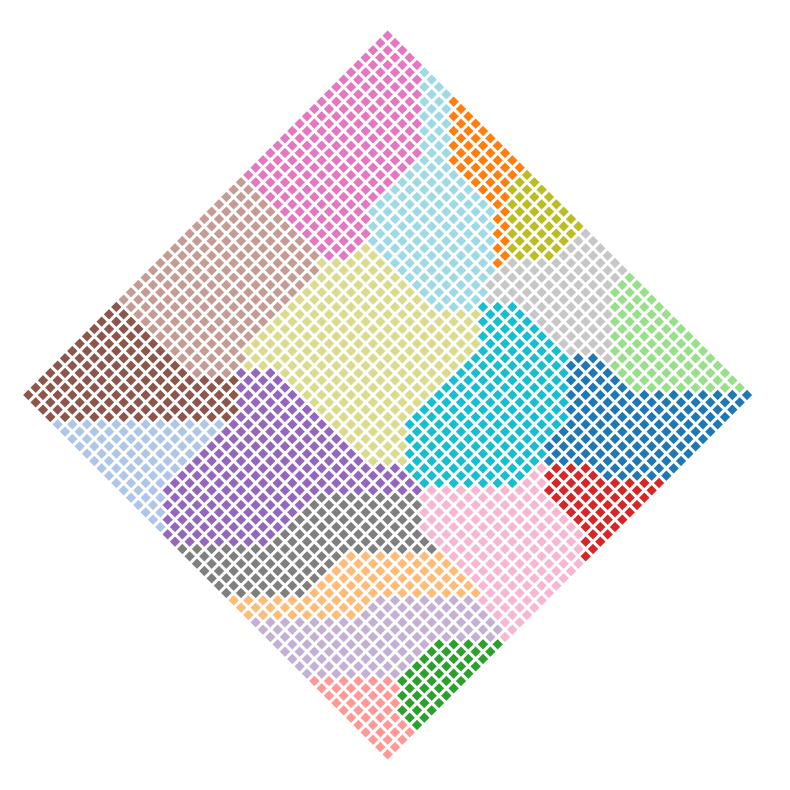

In [23]:
# Create a custom environment with exactly n=20 packages
class FixedPackageEnv(CoModalEnv):
    """Environment with a fixed number of packages instead of Poisson-distributed."""
    def __init__(self, n_packages: int, **kwargs):
        self.n_packages_fixed = n_packages
        super().__init__(**kwargs)
    
    def reset(self, seed: Optional[int] = None):
        if seed is not None:
            self.rng = np.random.default_rng(int(seed))
        
        # Force exactly n_packages_fixed packages instead of Poisson sampling
        n_pkg = self.n_packages_fixed
        pkg_list = [self._sample_uniform_point_in_diamond(self.R) for _ in range(n_pkg)]
        self.pkg_pos_all = np.asarray(pkg_list, dtype=np.float32)
        self.pkg_delivered = np.zeros(n_pkg, dtype=bool)
        self.pkg_remaining_idx = list(range(n_pkg))
        self.packages = self.pkg_pos_all[self.pkg_remaining_idx]

        # vehicle state
        self.pos = np.array([0.0, 0.0], dtype=np.float32)
        self.t = 0.0
        self.ride_buffer: List[Tuple[RideReq, int]] = []
        self.to_pickup: Optional[np.ndarray] = None
        self.with_passenger: bool = False
        self.drop_target: Optional[np.ndarray] = None

        self.revenue_cum = 0.0
        self._steps = 0
        self._ended_reason = None
        self.accepted_rides = 0
        
        self.time_rides_min = 0.0
        self.time_delivery_min = 0.0

        obs, mask = self._get_obs()
        return obs, mask

def plot_diamond_grid_voronoi(env: CoModalEnv, grid_size: int = 40, fixed_spacing: float = 0.05):
    """
    Plot Voronoi diagram using small diamond shapes in a diagonal grid pattern.
    Each small diamond is colored according to which Voronoi region it belongs to.
    The diamonds are arranged in a 45-degree rotated grid for perfect tiling.
    
    Parameters:
    - env: CoModalEnv with package positions
    - grid_size: number of diamonds along the diagonal (controls diamond size)
    - fixed_spacing: fixed absolute spacing between diamonds in original coordinate system
    """
    R = env.R
    seeds = env.pkg_pos_all
    
    # Get colormap
    n_colors = len(seeds)
    colors = plt.cm.tab20(np.linspace(0, 1, n_colors))
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Create a diagonal grid by using rotated coordinates
    # In the rotated coordinate system, diamonds become squares
    # u = (x + y) / sqrt(2), v = (x - y) / sqrt(2)
    
    sqrt2 = np.sqrt(2)
    R_rotated = R * sqrt2  # Range in the rotated coordinate system
    
    # Grid spacing in rotated coordinates
    grid_step_rotated = 2 * R_rotated / grid_size
    
    # Convert to original coordinate system:
    # A step of grid_step_rotated in the rotated system corresponds to 
    # a L1 distance of grid_step_rotated in the original system
    # For a diamond with vertices at (x, y±s) and (x±s, y), the L1 "diameter" is 2s
    
    # We want: 2s + fixed_spacing = grid_step_rotated (in rotated coords)
    # In original coords, grid_step_rotated in rotated system = grid_step_rotated in L1 distance
    # So: s = (grid_step_rotated - fixed_spacing) / 2
    s = max((grid_step_rotated - fixed_spacing) / 2.0, 0.01)
    
    # Create grid in rotated coordinates
    u_vals = np.arange(-R_rotated, R_rotated + grid_step_rotated/2, grid_step_rotated)
    v_vals = np.arange(-R_rotated, R_rotated + grid_step_rotated/2, grid_step_rotated)
    
    for u in u_vals:
        for v in v_vals:
            # Convert back to original coordinates
            x = (u + v) / sqrt2
            y = (u - v) / sqrt2
            
            # Check if point is inside the L1 diamond
            if abs(x) + abs(y) > R:
                continue
            
            # Find which Voronoi region this point belongs to
            dists = np.abs(seeds - np.array([x, y])[None, :]).sum(axis=1)
            owner = int(np.argmin(dists))
            
            # Draw a small diamond with vertices at (x, y±s) and (x±s, y)
            diamond_x = [x, x + s, x, x - s, x]
            diamond_y = [y + s, y, y - s, y, y + s]
            
            ax.fill(diamond_x, diamond_y, color=colors[owner], edgecolor='none', linewidth=0)
    
    ax.set_xlim([-R * 1.05, R * 1.05])
    ax.set_ylim([-R * 1.05, R * 1.05])
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Generate environment with exactly 20 packages
env_n20 = FixedPackageEnv(n_packages=20)
env_n20.reset(seed=42)

# Plot with diamond grid style matching the reference image
# fixed_spacing is now absolute (not relative), adjust grid_size to control diamond size
plot_diamond_grid_voronoi(env_n20, grid_size=100, fixed_spacing=0.0000001)


In [24]:

# =================
# Baseline policies
# =================
def run_episode(env: CoModalEnv, policy=None, greedy=False, seed: Optional[int] = None) -> Tuple[float, float, float, str, int, float, float]:
    obs, mask = env.reset(seed=seed)
    total = 0.0
    terminal_time = None
    ended_reason = "unknown"
    acc = 0
    t_rides = 0.0
    t_delivery = 0.0
    for _ in range(STEPS_PER_EP):
        if policy is None:
            # default: deliver-only baseline
            action = 0
        else:
            with torch.no_grad():
                o = torch.tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0)
                m = torch.tensor(mask, dtype=torch.float32, device=DEVICE).unsqueeze(0)
                logits, _ = policy(o)
                # mask invalid
                invalid = (m < 0.5)
                logits = logits.masked_fill(invalid, -1e9)
                if greedy:
                    action = int(torch.argmax(logits, dim=-1).item())
                else:
                    probs = torch.softmax(logits, dim=-1)
                    action = int(torch.multinomial(probs, 1).item())
        obs, r, done, info, mask = env.step(action)
        total += r
        if done:
            terminal_time = float(info.get("terminal_time_min", env.t))
            ended_reason = str(info.get("ended_reason", env._ended_reason or "unknown"))
            acc = int(info.get("accepted_rides", getattr(env, "accepted_rides", 0)))
            t_rides = float(info.get("time_rides_min", 0.0))
            t_delivery = float(info.get("time_delivery_min", 0.0))
            break
    if terminal_time is None:
        terminal_time = float(env.t)
        t_rides = float(getattr(env, "time_rides_min", 0.0))
        t_delivery = float(getattr(env, "time_delivery_min", 0.0))
        
    revenue_rate = total / terminal_time if terminal_time > 0 else 0.0
    
    return total, terminal_time, revenue_rate, ended_reason, acc, t_rides, t_delivery


def baseline_nearby_rule(env: CoModalEnv,
                         pickup_alpha=R_PICK_ALPHA,
                         drop_bias=0.5,
                         switch_grace_steps: Optional[int] = None,
                         seed: Optional[int] = None
                         ) -> Tuple[float, float, float, str, int, float, float]:
   
    obs, mask = env.reset(seed=seed)
    total = 0.0
    terminal_time = None
    ended_reason = "unknown"
    acc = 0
    t_rides = 0.0
    t_delivery = 0.0

    grace_left = 0

    for _ in range(STEPS_PER_EP):
        visible = env._visible_rides()
        action = 0  # Default: go to the nearest package
        
        gs = SWITCH_GRACE_STEPS if switch_grace_steps is None else int(switch_grace_steps)
        
        #Pre-grace
        # If the nearest package can be delivered in the next step, open the window in advance
        nn = env._nearest_package()
        if nn is not None:
            dist_to_nn = manhattan(env.pos, nn)
            if grace_left == 0 and dist_to_nn <= (env.v * env.dt):
                grace_left = max(1, gs)
                

        if grace_left > 0:
            # Inside the window: as long as there is a qualified order, accept the one with the nearest pickup
            if len(visible) > 0:
                # if cap is set, only consider rides with pickup distance <= cap
                if HEUR_SOFT_PICK_CAP is not None:
                    cand = [(i, r) for i, r in enumerate(visible)
                            if manhattan(env.pos, r.pickup) <= HEUR_SOFT_PICK_CAP]
                else:
                    cand = list(enumerate(visible))

                if cand:
                    # pick the candidate with the smallest pickup distance
                    best_i = min(cand, key=lambda ir: manhattan(env.pos, ir[1].pickup))[0]
                    action = 1 + best_i
                    grace_left = 0
                else:
                    # no ride within the cap → keep window open and continue delivering
                    grace_left -= 1
            else:
                grace_left -= 1

        # Execute action
        obs, r, done, info, mask = env.step(action)
        total += r

        delivered_cnt = int(info.get("delivered_step", 0))
        if delivered_cnt > 0:
            # After delivering the package: open a new window (including the current and subsequent SWITCH_GRACE_STEPS steps)
            grace_left = max(1, gs)


        if done:
            terminal_time = float(info.get("terminal_time_min", env.t))
            ended_reason  = str(info.get("ended_reason", env._ended_reason or "unknown"))
            acc = int(info.get("accepted_rides", getattr(env, "accepted_rides", 0)))
            t_rides = float(info.get("time_rides_min", 0.0))
            t_delivery = float(info.get("time_delivery_min", 0.0))
            break

    if terminal_time is None:
        terminal_time = float(env.t)
    revenue_rate = (total / terminal_time) if terminal_time > 0 else 0.0
    return total, terminal_time, revenue_rate, ended_reason, acc, t_rides, t_delivery


def baseline_nearby_rule_voronoi(env: CoModalEnv,
                                 pickup_alpha=R_PICK_ALPHA,
                                 drop_bias=0.5,
                                 switch_grace_steps: Optional[int] = None,
                                 seed: Optional[int] = None
                                 ) -> Tuple[float, float, float, str, int, float, float]:
    """
    Switching policy (N=n) + L1-Voronoi dropoff filter:
      - Only consider accepting rides within a window of a few steps after delivering a package.
      - Filter candidate passengers first: the dropoff must not fall into the L1-Voronoi cell of a delivered package.
      - If there are still candidates after filtering, accept the one with the nearest pickup; otherwise, continue delivering the nearest package.
    Returns: (total_reward, terminal_time_min, revenue_rate, ended_reason, accepted_rides)
    """
    obs, mask = env.reset(seed=seed)
    total = 0.0
    terminal_time = None
    ended_reason = "unknown"
    acc = 0
    grace_left = 0
    t_rides = 0.0
    t_delivery = 0.0

    gs = SWITCH_GRACE_STEPS if switch_grace_steps is None else int(switch_grace_steps)

    for _ in range(STEPS_PER_EP):
        visible = env._visible_rides()
        action = 0

        # If the nearest package can be delivered in the next step, open the window in advance
        nn = env._nearest_package()
        if nn is not None:
            dist_to_nn = manhattan(env.pos, nn)
            if grace_left == 0 and dist_to_nn <= (env.v * env.dt):
                grace_left = max(1, gs)

        if grace_left > 0:
            # First, use the Voronoi rule to filter out rides whose dropoff falls into a delivered package's cell
            cand = [r for r in visible if env.dropoff_allowed(r.dropoff)]
            if len(cand) > 0:
                # Accept the ride with the nearest pickup
                pk_d_list = [manhattan(env.pos, r.pickup) for r in cand]
                action = 1 + int(np.argmin(pk_d_list))
                grace_left = 0
            else:
                grace_left -= 1

        obs, r, done, info, mask = env.step(action)
        total += r

        delivered_cnt = int(info.get("delivered_step", 0))   # Note: your env uses "delivered_step"
        if delivered_cnt > 0:
            grace_left = max(1, gs)

        if done:
            terminal_time = float(info.get("terminal_time_min", env.t))
            ended_reason  = str(info.get("ended_reason", env._ended_reason or "unknown"))
            acc = int(info.get("accepted_rides", getattr(env, "accepted_rides", 0)))
            t_rides = float(info.get("time_rides_min", 0.0))
            t_delivery = float(info.get("time_delivery_min", 0.0))
            break

    if terminal_time is None:
        terminal_time = float(env.t)
        t_rides = float(getattr(env, "time_rides_min", 0.0))
        t_delivery = float(getattr(env, "time_delivery_min", 0.0))
        
    revenue_rate = (total / terminal_time) if terminal_time > 0 else 0.0
    return total, terminal_time, revenue_rate, ended_reason, acc, t_rides, t_delivery


def baseline_pure_ortools(env: CoModalEnv, seed: Optional[int] = None) -> Tuple[float, float, float, str, int, float, float]:
    """
    Pure delivery baseline: Use OR-Tools to solve an L1-TSP for all package points in the current episode,
    then force the environment to strictly follow this order to clear packages one by one (completely ignoring passengers).
    Returns: (total_reward, terminal_time_min, revenue_rate, ended_reason, accepted_rides=0, time_rides, time_delivery)
    """
    obs, mask = env.reset(seed=seed)
    total = 0.0
    terminal_time = None
    ended_reason = "unknown"
    t_rides = 0.0
    t_delivery = 0.0

    # ---- Collect package points & starting point ----
    pkgs = env.packages                     # view: updates with remaining set, but we only use the initial full set to plan the route once
    start_xy = (float(env.pos[0]), float(env.pos[1]))
    pkg_pts = [(float(p[0]), float(p[1])) for p in pkgs]

    # ---- Build integer distance matrix (with scaling) ----
    SCALE = 1000  # Avoid short edges being rounded to 0
    def _l1_int(a, b):
        return int(round((abs(a[0]-b[0]) + abs(a[1]-b[1])) * SCALE))

    def _build_dist(pts):
        n = len(pts)
        mat = [[0]*n for _ in range(n)]
        for i in range(n):
            for j in range(n):
                if i != j:
                    mat[i][j] = _l1_int(pts[i], pts[j])
        return mat

    # ---- Solve TSP once: depot=start, nodes=packages ----
    def _solve_tsp(order_pts):
        if not order_pts:
            return []
        all_pts = [start_xy] + order_pts
        dist = _build_dist(all_pts)
        n_nodes = len(all_pts)
        manager = pywrapcp.RoutingIndexManager(n_nodes, 1, 0)     # 1 vehicle, depot=0
        routing = pywrapcp.RoutingModel(manager)

        def cb(from_idx, to_idx):
            i = manager.IndexToNode(from_idx)
            j = manager.IndexToNode(to_idx)
            return dist[i][j]

        cb_idx = routing.RegisterTransitCallback(cb)
        routing.SetArcCostEvaluatorOfAllVehicles(cb_idx)

        params = pywrapcp.DefaultRoutingSearchParameters()
        params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
        params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
        params.time_limit.FromSeconds(2)  # Sufficient for small instances

        sol = routing.SolveWithParameters(params)
        if sol is None:
            # Fallback: Sort by L1 nearest neighbor from the starting point
            return sorted(range(len(order_pts)),
                          key=lambda k: abs(order_pts[k][0]-start_xy[0]) + abs(order_pts[k][1]-start_xy[1]))

        # Read route: Remove depot, convert to index sequence of original order_pts
        idx = routing.Start(0)
        order = []
        while not routing.IsEnd(idx):
            node = manager.IndexToNode(idx)
            if node != 0:
                order.append(node - 1)
            idx = sol.Value(routing.NextVar(idx))
        return order

    route_idx = _solve_tsp(pkg_pts)
    route = [pkgs[i] for i in route_idx]   # Fixed visiting sequence (slice of np.array), clear packages point by point
    route_ptr = 0

    # ---- force env._nearest_package to be the TSP order ----
    orig_nearest = env._nearest_package
    def _forced_nearest():
        nonlocal route_ptr
        if route_ptr < len(route):
            return route[route_ptr]
        return None
    env._nearest_package = _forced_nearest

    try:
        for _ in range(STEPS_PER_EP):
            action = 0  # Always package delivery
            obs, r, done, info, mask = env.step(action)
            total += r

            # This step may reach multiple package points at the same coordinates at once (theoretically allowed), use delivered_step to advance pointer
            delivered_cnt = int(info.get("delivered_step", 0))
            if delivered_cnt > 0:
                route_ptr = min(route_ptr + delivered_cnt, len(route))

            if done:
                terminal_time = float(info.get("terminal_time_min", env.t))
                ended_reason  = str(info.get("ended_reason", env._ended_reason or "unknown"))
                t_rides = float(info.get("time_rides_min", 0.0))
                t_delivery = float(info.get("time_delivery_min", 0.0))
                break

        if terminal_time is None:
            terminal_time = float(env.t)
            t_rides = float(getattr(env, "time_rides_min", 0.0))
            t_delivery = float(getattr(env, "time_delivery_min", 0.0))
    finally:
        # Restore environment method
        env._nearest_package = orig_nearest

    revenue_rate = total / terminal_time if terminal_time > 0 else 0.0
    return total, terminal_time, revenue_rate, ended_reason, 0, t_rides, t_delivery




In [25]:
# =================
# Four zone baseline policies relevant
# =================

# =========================
# Four-zone helpers (L1)
# =========================

def l1_zone_id(p: np.ndarray) -> int:
    """
    Divides the diamond-shaped region into four zones based on L1 criteria:
      zone 0: |x|>=|y| and x>=0  -> Right
      zone 1: |x|>=|y| and x<0   -> Left
      zone 2: |y|>|x| and y>=0   -> Top
      zone 3: |y|>|x| and y<0    -> Bottom
    """
    x, y = float(p[0]), float(p[1])
    if abs(x) >= abs(y):
        return 0 if x >= 0 else 1
    else:
        return 2 if y >= 0 else 3


def _l1_distance(a: Tuple[float,float], b: Tuple[float,float]) -> int:
    # OR-Tools requires an integer matrix; here we use an integer approximation by scaling by 1000, or simply rounding.
    return int(round(abs(a[0]-b[0]) + abs(a[1]-b[1])))


def _build_distance_matrix_L1(pts: List[Tuple[float,float]]) -> List[List[int]]:
    n = len(pts)
    mat = [[0]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j:
                mat[i][j] = _l1_distance(pts[i], pts[j])
    return mat


def solve_zone_tsp_L1(points_xy: List[Tuple[float,float]],
                      start_xy: Tuple[float,float]) -> List[int]:
    """
    Given package points within a zone (points_xy) and a starting point (start_xy),
    use OR-Tools to solve an approximate TSP visiting order and return the index sequence for visiting points_xy.
    - We construct a virtual depot = start_xy, connected to all points;
    - The goal is to visit all points starting from the depot (end point is arbitrary).
    """
    if not points_xy:
        return []

    # Construct node list: node 0 = depot (start), 1..n = package points
    all_points = [start_xy] + list(points_xy)
    dist = _build_distance_matrix_L1(all_points)

    n_nodes = len(all_points)
    manager = pywrapcp.RoutingIndexManager(n_nodes, 1, 0)   # Single vehicle, depot=0
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        i = manager.IndexToNode(from_index)
        j = manager.IndexToNode(to_index)
        return dist[i][j]

    transit_cb_idx = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_cb_idx)

    # Allow not returning to the depot; by default, it will find a path starting from the depot
    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_params.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_params.time_limit.FromSeconds(2)  # Sufficient for small scale

    solution = routing.SolveWithParameters(search_params)
    if solution is None:
        # Fallback: If OR-Tools provides no solution, sort by nearest neighbor from the start
        order = sorted(range(len(points_xy)),
                       key=lambda k: abs(points_xy[k][0]-start_xy[0]) + abs(points_xy[k][1]-start_xy[1]))
        return order

    # Parse path: node number -> points index (subtract 1)
    idx = routing.Start(0)
    visit_order = []
    while not routing.IsEnd(idx):
        node = manager.IndexToNode(idx)
        if node != 0:  # Skip depot
            visit_order.append(node - 1)
        idx = solution.Value(routing.NextVar(idx))
    return visit_order

# =================
# Four zone baseline algorithm
# =================


def baseline_four_zone(env: CoModalEnv,
                       r_pick_alpha: float = R_PICK_ALPHA,
                       screen_window_min: float = 10.0,
                       seed: Optional[int] = None
                       ) -> Tuple[float, float, float, str, int, float, float]:
    """
    Four-Zone Policy (FZ):
      1) Divide all packages into 4 zones by l1_zone_id and clear them one by one;
      2) Within a zone, use OR-Tools to find an approximate TSP visiting order and follow it strictly;
      3) In the "final leg" within a zone, open a passenger screening window (lasting screen_window_min minutes):
           Only consider visible rides where pickup is within r_pick, TTL is valid, and dropoff is in an "unserved" zone;
         but **only accept a ride after clearing the current zone** (if it's still visible); if no rides, proceed to the next unserved zone;
      4) After completing a ride, if it lands in an unserved zone, that zone becomes the next one to service.
    Output is consistent with other baselines: (reward, terminal_time, rate, ended_reason, accepted)
    """
    obs, mask = env.reset(seed=seed)
    total, terminal_time = 0.0, None
    ended_reason = "unknown"
    acc = 0
    t_rides = 0.0
    t_delivery = 0.0

    # Pre-fetch constants
    r_pick = r_pick_alpha * env.R / math.sqrt(2.0)
    screen_steps = max(1, int(round(screen_window_min / env.dt)))

    # Initial partitioning based on packages at reset
    def packages_by_zone():
        zones = {0: [], 1: [], 2: [], 3: []}
        for p in env.packages:
            zones[l1_zone_id(p)].append((float(p[0]), float(p[1])))
        return zones

    zones = packages_by_zone()

    def zone_has_pkg(zid: int) -> bool:
        return len(zones[zid]) > 0

    def pick_next_zone(cur_pos: np.ndarray) -> Optional[int]:
        # Select the "nearest un-cleared zone" (measured by L1 distance to the nearest package in that zone)
        best, best_d = None, 1e18
        for zid in range(4):
            if not zone_has_pkg(zid):
                continue
            d_min = min(abs(px-cur_pos[0]) + abs(py-cur_pos[1]) for (px,py) in zones[zid])
            if d_min < best_d:
                best, best_d = zid, d_min
        return best

    # Plan TSP order for a zone (based on current env.pos)
    def plan_zone_route(zid: int) -> List[Tuple[float,float]]:
        pts = zones[zid]
        order = solve_zone_tsp_L1(pts, (float(env.pos[0]), float(env.pos[1])))
        return [pts[k] for k in order]

    # Filter acceptable passengers (meeting r_pick/TTL and dropoff in an unserved zone)
    def screened_visible_in_unserved():
        cand = []
        visible = env._visible_rides()
        unserved_zids = {z for z in range(4) if zone_has_pkg(z)}
        for r in visible:
            zid = l1_zone_id(r.dropoff)
            if zid in unserved_zids:
                # Re-verify pickup distance (env._visible_rides already filters by TTL+radius)
                if manhattan(env.pos, r.pickup) <= r_pick:
                    cand.append(r)
        # Select the one with the nearest pickup
        cand.sort(key=lambda rr: manhattan(env.pos, rr.pickup))
        return cand

    current_zone = pick_next_zone(env.pos)
    route = plan_zone_route(current_zone) if current_zone is not None else []

    # Route pointer & screening window counter
    idx_in_route = 0
    screen_left = 0
    have_candidate = False   # Flag that a qualified ride is available, but wait until the zone is clear to accept

    for _ in range(STEPS_PER_EP):
        action = 0  # Default to delivering packages
        # If no current zone, try to pick one
        if current_zone is None:
            current_zone = pick_next_zone(env.pos)
            if current_zone is not None:
                route = plan_zone_route(current_zone)
                idx_in_route = 0

        # If there are still target points in the zone, move towards the next one
        if current_zone is not None and idx_in_route < len(route):
            target = np.array(route[idx_in_route], dtype=np.float32)
            # If the next step is reachable (will arrive at the point), open the screening window in the "final leg"
            dist_to_target = manhattan(env.pos, target)
            if screen_left == 0 and dist_to_target <= (env.v * env.dt):
                screen_left = screen_steps

        # Within the screening window: only screen, do not accept (until the zone is cleared)
        if screen_left > 0:
            screen_left -= 1
            cand = screened_visible_in_unserved()
            have_candidate = have_candidate or (len(cand) > 0)

        # Select action
        if env.to_pickup is not None or env.with_passenger:
            # Currently picking up/transporting a passenger, action is ignored
            pass
        else:
            # If the current zone is cleared (determined at runtime based on env.packages), allow trying to accept a ride
            # We consider the zone cleared if: zones[current_zone] ∩ env.packages == ∅
            if current_zone is not None:
                # Synchronize zones: remove delivered packages from zones (by coordinate matching)
                # Note: env._deliver_if_arrived() is only triggered upon arrival at a point, here we use approximate matching
                alive = set((float(p[0]), float(p[1])) for p in env.packages)
                zones[current_zone] = [pt for pt in zones[current_zone] if pt in alive]

                if len(zones[current_zone]) == 0:
                    # Current zone cleared: if there's a qualified candidate and it's still visible, accept it now (otherwise, move to the next un-cleared zone)
                    if have_candidate:
                        visible = env._visible_rides()
                        # Pick one based on nearest pickup and dropoff in an unserved zone
                        best_idx, best_d = -1, 1e18
                        for i, r in enumerate(visible):
                            if l1_zone_id(r.dropoff) in {z for z in range(4) if zone_has_pkg(z)}:
                                d = manhattan(env.pos, r.pickup)
                                if d < best_d:
                                    best_d, best_idx = d, i
                        if best_idx >= 0:
                            action = 1 + best_idx
                            have_candidate = False
                    # If no qualified ride was accepted, move to the next un-cleared zone and replan
                    if action == 0:
                        current_zone = pick_next_zone(env.pos)
                        if current_zone is not None:
                            route = plan_zone_route(current_zone)
                            idx_in_route = 0

            # Not transporting a passenger and no ride acceptance triggered, so continue delivering packages along the route
            # (Based on the "deliver only upon arrival" mechanism in env.step, action=0 is sufficient)
            pass

        # Execute action
        obs, r, done, info, mask = env.step(action)
        total += r
        if done:
            terminal_time = float(info.get("terminal_time_min", env.t))
            ended_reason  = str(info.get("ended_reason", env._ended_reason or "unknown"))
            acc = int(info.get("accepted_rides", getattr(env, "accepted_rides", 0)))
            t_rides = float(info.get("time_rides_min", 0.0))
            t_delivery = float(info.get("time_delivery_min", 0.0))
            break

        # If a delivery was just successful, advance the route pointer (using the delivered_step flag)
        delivered_cnt = int(info.get("delivered_step", 0))
        if delivered_cnt > 0 and current_zone is not None and idx_in_route < len(route):
            # If current position equals route[idx], move forward
            cur = (float(env.pos[0]), float(env.pos[1]))
            if idx_in_route < len(route) and cur == route[idx_in_route]:
                idx_in_route += 1

    if terminal_time is None:
        terminal_time = float(env.t)
    revenue_rate = total / terminal_time if terminal_time > 0 else 0.0
    return total, terminal_time, revenue_rate, ended_reason, acc, t_rides, t_delivery



In [26]:

# ==============
# PPO Components
# ==============
class ActorCritic(nn.Module):
    def __init__(self, obs_dim: int, act_dim: int):
        super().__init__()
        hid = 256
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hid), 
            nn.LayerNorm(hid),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hid, hid), 
            nn.LayerNorm(hid),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        self.pi = nn.Linear(hid, act_dim)
        self.v  = nn.Linear(hid, 1)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h = self.net(x)
        return self.pi(h), self.v(h)


def ppo_update(policy: ActorCritic, optimizer, batch, clip_eps=CLIP_EPS):
    obs, act, old_logp, ret, adv, mask = batch
    logits, v = policy(obs)
    # mask invalid actions
    invalid = (mask < 0.5)
    logits = logits.masked_fill(invalid, -1e9)
    dist = torch.distributions.Categorical(logits=logits)
    logp = dist.log_prob(act)
    ratio = torch.exp(logp - old_logp)

    clip_adv = torch.clamp(ratio, 1.0 - clip_eps, 1.0 + clip_eps) * adv
    pi_loss = -(torch.min(ratio * adv, clip_adv)).mean()
    v_loss = ((ret - v.squeeze(-1)) ** 2).mean()

    ent = dist.entropy().mean()
    loss = pi_loss + VF_COEF * v_loss - ENT_COEF * ent

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
    optimizer.step()

    return pi_loss.item(), v_loss.item(), ent.item(), loss.item()


def collect_rollout(env: CoModalEnv, policy: ActorCritic, steps: int):
    # buffers
    obs_buf, act_buf, rew_buf, val_buf, next_val_buf, logp_buf, mask_buf, done_buf = [], [], [], [], [], [], [], []
    ep_returns, ep_lens = [], []
    cur_ret = 0.0; cur_len = 0

    obs, mask = env.reset()
    for _ in range(steps):
        o = torch.tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        m = torch.tensor(mask, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        with torch.no_grad():
            logits, v = policy(o)
            invalid = (m < 0.5)
            logits = logits.masked_fill(invalid, -1e9)
            dist = torch.distributions.Categorical(logits=logits)
            a = dist.sample()
            logp = dist.log_prob(a).squeeze(0)
            v_cur = v.squeeze(0).squeeze(-1)             # V(s_t)

        # step env
        obs2, r, done, _, mask2 = env.step(int(a.item()))

        # compute V(s_{t+1}) for GAE bootstrap
        with torch.no_grad():
            o2 = torch.tensor(obs2, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            _, v_next = policy(o2)
            v_next = v_next.squeeze(0).squeeze(-1)       # V(s_{t+1})

        # store
        obs_buf.append(o.squeeze(0).cpu().numpy())
        mask_buf.append(m.squeeze(0).cpu().numpy())
        act_buf.append(a.cpu().numpy())
        rew_buf.append(r)
        val_buf.append(v_cur.cpu().numpy())
        next_val_buf.append(v_next.cpu().numpy())
        logp_buf.append(logp.cpu().numpy())
        done_buf.append(done)

        # track episode return/len
        cur_ret += r
        cur_len += 1
        obs, mask = obs2, mask2
        if done:
            ep_returns.append(cur_ret)
            ep_lens.append(cur_len)
            cur_ret = 0.0; cur_len = 0
            obs, mask = env.reset()

    # ---------- GAE(λ) advantages & returns ----------
    rewards = np.array(rew_buf, dtype=np.float32)
    values  = np.array(val_buf, dtype=np.float32)
    next_values = np.array(next_val_buf, dtype=np.float32)
    dones   = np.array(done_buf, dtype=np.float32)  # 1.0 if done else 0.0

    advantages = np.zeros_like(rewards, dtype=np.float32)
    gae = 0.0
    gamma = DISCOUNT
    lam = GAE_LAMBDA
    for t in reversed(range(len(rewards))):
        nonterminal = 1.0 - dones[t]
        delta = rewards[t] + gamma * next_values[t] * nonterminal - values[t]
        gae = delta + gamma * lam * nonterminal * gae
        advantages[t] = gae

    returns = advantages + values  # target for value head

    obs_t  = torch.tensor(np.array(obs_buf), dtype=torch.float32, device=DEVICE)
    act_t  = torch.tensor(np.array(act_buf).squeeze(-1), dtype=torch.long, device=DEVICE)
    ret_t  = torch.tensor(returns, dtype=torch.float32, device=DEVICE)
    adv_t  = torch.tensor(advantages, dtype=torch.float32, device=DEVICE)
    logp_t = torch.tensor(np.array(logp_buf), dtype=torch.float32, device=DEVICE)
    mask_t = torch.tensor(np.array(mask_buf), dtype=torch.float32, device=DEVICE)

    adv_t = (adv_t - adv_t.mean()) / (adv_t.std() + 1e-8)

    step_avg_reward = float(rewards.mean()) if len(rewards) > 0 else float('nan')
    step_avg_rate = step_avg_reward / DT if not np.isnan(step_avg_reward) else float('nan')
    ep_stats = []
    for ret, ln in zip(ep_returns, ep_lens):
        t_min = ln * DT
        rate = ret / t_min if t_min > 0 else 0.0
        ep_stats.append({'reward': ret, 'steps': ln, 'terminal_time_min': t_min, 'rate': rate})

    return (obs_t, act_t, logp_t, ret_t, adv_t, mask_t), ep_stats, step_avg_reward, step_avg_rate
def make_minibatches(batch, batch_size):
    N = batch[0].shape[0]
    idx = np.arange(N)
    rng.shuffle(idx)
    for i in range(0, N, batch_size):
        j = idx[i:i+batch_size]
        yield tuple(x[j] for x in batch)


In [27]:
# --- add: helper to build a fresh evaluation env cloned from a training env ---
def _make_eval_env_from(env: CoModalEnv) -> CoModalEnv:
    
    rt_unscaled = env.rt * INV_REWARD_SCALE
    rp_unscaled = env.rp * INV_REWARD_SCALE
    r_pick_alpha = (env.r_pick * math.sqrt(2.0)) / env.R
    ride_ttl_minutes = env.ride_ttl_steps * env.dt
    return CoModalEnv(
        R=env.R, v=env.v, dt=env.dt,
        lam=env.lam, gamma_pack=env.gamma,
        rp=rp_unscaled, rt=rt_unscaled,
        r_pick_alpha=r_pick_alpha,
        ride_ttl_minutes=ride_ttl_minutes,
        max_visible=env.max_visible
    )


In [28]:
def evaluate_all(env: CoModalEnv, policy: ActorCritic, heur_grace_steps: Optional[int] = None):
    # --- use a fresh env so that seeding for eval won't affect the training env RNG ---
    eval_env = _make_eval_env_from(env)

    # --- snapshot & restore torch RNG (CPU/CUDA), ensure evaluation doesn't change training random trajectory ---
    prev_mode = policy.training
    cpu_state = torch.random.get_rng_state()
    cuda_state = torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None

    policy.eval()
    try:
        base = 42
        seeds = [base + i for i in range(EVAL_EPISODES)]

        # Note: all episodes below use eval_env, not the training env
        drl_eps   = [run_episode(eval_env, policy, greedy=True, seed=s)        for s in seeds]
        pure_eps  = [run_episode(eval_env, policy=None,        seed=s)         for s in seeds]
        pure_or_eps = [baseline_pure_ortools(eval_env, seed=s) for s in seeds]
        heur_eps  = [baseline_nearby_rule(eval_env, switch_grace_steps=heur_grace_steps, seed=s)  for s in seeds]
        hv_eps    = [baseline_nearby_rule_voronoi(eval_env, switch_grace_steps=heur_grace_steps, seed=s) for s in seeds]
        fz_eps    = [baseline_four_zone(eval_env, seed=s) for s in seeds]

        
        def _descale_eps(eps):
            if not REPORT_UNSCALED: return eps
            fixed = []
            for e in eps:
                if len(e) == 7:
                    R, T, Rate, reason, acc, t_R, t_D = e
                    fixed.append((R * INV_REWARD_SCALE, T, Rate * INV_REWARD_SCALE, reason, acc, t_R, t_D))
                elif len(e) == 5:
                    R, T, Rate, reason, acc = e
                    fixed.append((R * INV_REWARD_SCALE, T, Rate * INV_REWARD_SCALE, reason, acc))
                else:
                    R, T, Rate, reason = e
                    fixed.append((R * INV_REWARD_SCALE, T, Rate * INV_REWARD_SCALE, reason))
            return fixed

        drl_out = _descale_eps(drl_eps)
        pure_out= _descale_eps(pure_eps)
        pure_or_out= _descale_eps(pure_or_eps)
        heur_out= _descale_eps(heur_eps)
        hv_out  = _descale_eps(hv_eps)
        fz_out  = _descale_eps(fz_eps)

        def agg(eps):
            R  = np.array([e[0] for e in eps], dtype=float)
            T  = np.array([e[1] for e in eps], dtype=float)
            Rt = np.array([e[2] for e in eps], dtype=float)
            reasons = [e[3] for e in eps]
            out = dict(avg_reward=float(R.mean()), avg_t=float(T.mean()), avg_rate=float(Rt.mean()))
            done_mask = np.array([1.0 if r == "packages_done" else 0.0 for r in reasons], dtype=float)
            finish_cnt = int(done_mask.sum()); out["finish_rate"] = float(finish_cnt / len(eps))
            out["avg_finish_time"] = float(T[done_mask == 1].mean()) if finish_cnt > 0 else float("nan")
            if len(eps[0]) == 5:
                A  = np.array([e[4] for e in eps], dtype=float); out["avg_acc"] = float(A.mean())
            if len(eps[0]) == 7:
                A  = np.array([e[4] for e in eps], dtype=float); out["avg_acc"] = float(A.mean())
                tR = np.array([e[5] for e in eps], dtype=float)
                tD = np.array([e[6] for e in eps], dtype=float)
                out["avg_time_rides"] = float(tR.mean()); out["avg_time_delivery"] = float(tD.mean())
            return out

        def pprint(name, eps):
            print(f"  {name} episodes:")
            if len(eps[0]) == 7:
                for i, (R, T, rate, reason, acc, tR, tD) in enumerate(eps):
                    mark = " (early-packages-done)" if reason == "packages_done" else ""
                    print(f"    Ep{i+1:02d}: reward={R:8.2f}, terminal_time={T:7.2f} min, rate={rate:6.3f}/min, accepted={acc:3d}, reason={reason}{mark}, time_rides={tR:7.2f} min, time_delivery={tD:7.2f} min")
            elif len(eps[0]) == 5:
                for i, (R, T, rate, reason, acc) in enumerate(eps):
                    mark = " (early-packages-done)" if reason == "packages_done" else ""
                    print(f"    Ep{i+1:02d}: reward={R:8.2f}, terminal_time={T:7.2f} min, rate={rate:6.3f}/min, accepted={acc:3d}, reason={reason}{mark}")
            else:
                for i, (R, T, rate, reason) in enumerate(eps):
                    mark = " (early-packages-done)" if reason == "packages_done" else ""
                    print(f"    Ep{i+1:02d}: reward={R:8.2f}, terminal_time={T:7.2f} min, rate={rate:6.3f}/min, reason={reason}{mark}")

        pprint("DRL ", drl_out)
        pprint("HEUR", heur_out)
        pprint("HVOR", hv_out)
        pprint("FZ",   fz_out)
        pprint("PURO", pure_or_out)
        pprint("PURE", pure_out)

        return {
            "drl":       agg(drl_out),
            "heur":      agg(heur_out),
            "heur_vor":  agg(hv_out),
            "four_zone": agg(fz_out),
            "pure":      agg(pure_out),
            "pure_or":   agg(pure_or_out),
        }
    finally:
        # Restore torch RNG & model mode
        torch.random.set_rng_state(cpu_state)
        if cuda_state is not None:
            torch.cuda.set_rng_state_all(cuda_state)
        if prev_mode:
            policy.train()


In [29]:


def main():
    env = CoModalEnv()
    policy = ActorCritic(env.obs_dim, env.act_dim).to(DEVICE)
    policy.train()
    optimizer = optim.Adam(policy.parameters(), lr=LR)

    print(f"Device: {DEVICE}, obs_dim={env.obs_dim}, act_dim={env.act_dim}")
    print("Start training PPO...")
    for upd in range(1, UPDATES + 1):
        batch = collect_rollout(env, policy, PPO_STEPS)
        for _ in range(PPO_EPOCHS):
            for mb in make_minibatches(batch, PPO_MINI_BATCH):
                pi_l, v_l, ent, tot = ppo_update(policy, optimizer, mb, CLIP_EPS)
        if upd % 5 == 0:
            metrics = evaluate_all(env, policy)
            drl  = metrics["drl"]
            heur = metrics["heur"]
            hv   = metrics["heur_vor"]
            fz   = metrics["four_zone"]
            pure = metrics["pure"]
            pure_or = metrics["pure_or"]
            print(f"[Upd {upd:03d}] "
                f"DRL:  R={drl['avg_reward']:8.2f}, T={drl['avg_t']:7.2f}m, "
                f"Rate={drl['avg_rate']:6.3f}/m, Acc={drl.get('avg_acc', float('nan')):5.2f}, "
                f"FinRate={drl['finish_rate']:.2f}, FinishT={(np.nan if np.isnan(drl['avg_finish_time']) else drl['avg_finish_time']):.2f} | "
                f"HEUR: R={heur['avg_reward']:8.2f}, T={heur['avg_t']:7.2f}m, "
                f"Rate={heur['avg_rate']:6.3f}/m, FinRate={heur['finish_rate']:.2f}, "
                f"FinishT={(np.nan if np.isnan(heur['avg_finish_time']) else heur['avg_finish_time']):.2f} | "
                f"HVOR: R={hv['avg_reward']:8.2f}, T={hv['avg_t']:7.2f}m, "
                f"Rate={hv['avg_rate']:6.3f}/m, FinRate={hv['finish_rate']:.2f}, "
                f"FinishT={(np.nan if np.isnan(hv['avg_finish_time']) else hv['avg_finish_time']):.2f} | "
                f"FZON: R={fz['avg_reward']:8.2f}, T={fz['avg_t']:7.2f}m, "
                f"Rate={fz['avg_rate']:6.3f}/m, FinRate={fz['finish_rate']:.2f}, "
                f"FinishT={(np.nan if np.isnan(fz['avg_finish_time']) else fz['avg_finish_time']):.2f} | "
                f"PURE: R={pure['avg_reward']:8.2f}, T={pure['avg_t']:7.2f}m, "
                f"Rate={pure['avg_rate']:6.3f}/m, FinRate={pure['finish_rate']:.2f}, "
                f"FinishT={(np.nan if np.isnan(pure['avg_finish_time']) else pure['avg_finish_time']):.2f} | "
                f"PURO: R={pure_or['avg_reward']:8.2f}, T={pure_or['avg_t']:7.2f}m, "
                f"Rate={pure_or['avg_rate']:6.3f}/m, FinRate={pure_or['finish_rate']:.2f}, "
                f"FinishT={(np.nan if np.isnan(pure_or['avg_finish_time']) else pure_or['avg_finish_time']):.2f} "
                f"|| pi={pi_l:.3f} v={v_l:.3f} ent={ent:.3f}")



    # Final evaluation
    metrics = evaluate_all(env, policy)
    drl  = metrics["drl"]
    heur = metrics["heur"]
    hv   = metrics["heur_vor"]
    fz   = metrics["four_zone"]
    pure = metrics["pure"]
    pure_or = metrics["pure_or"]

    print("="*80)
    print(f"Final evaluation over {EVAL_EPISODES} eps (<= {HORIZON_MIN:.0f} min each):")
    def _fmt(name, m):
        return (f"{name:>18}: R={m['avg_reward']:.2f}, T={m['avg_t']:.2f}m, "
                f"Rate={m['avg_rate']:.3f}/m, FinRate={m['finish_rate']:.2f}, "
                f"FinishT={(np.nan if np.isnan(m['avg_finish_time']) else m['avg_finish_time']):.2f}m")
    print(_fmt("DRL (greedy)", drl))
    print(_fmt("Nearby heuristic", heur))
    print(_fmt("Heur. + Voronoi", hv))
    print(_fmt("Four-Zone heuristic", fz))
    print(_fmt("Pure delivery only", pure))
    print(_fmt("Pure (OR-Tools)", pure_or))




In [30]:
# Uncomment to run the main function, which will run everything with a single parameter combination.
#if __name__ == "__main__":
#    main()

In [31]:

# =========================
# Grid runner & CSV logger
# =========================

import os, csv
TRAIN_LOG_PATH = 'Results/training_log.csv'

def append_training_log(log_path, update, kind, ep_stats=None, step_avg_reward=None, step_avg_rate=None, meta=None):
    meta = meta or {}
    ep_stats = ep_stats or []
    agg = {
        'reward': np.mean([e['reward'] for e in ep_stats]) * INV_REWARD_SCALE if ep_stats else float('nan'),
        'rate': np.mean([e['rate'] for e in ep_stats]) * INV_REWARD_SCALE if ep_stats else float('nan'),
        'terminal_time_min': np.mean([e['terminal_time_min'] for e in ep_stats]) if ep_stats else float('nan'),
        'steps': np.mean([e['steps'] for e in ep_stats]) if ep_stats else float('nan'),
        'episodes': len(ep_stats),
        'step_avg_reward': step_avg_reward * INV_REWARD_SCALE if step_avg_reward is not None else float('nan'),
        'step_avg_rate': step_avg_rate * INV_REWARD_SCALE if step_avg_rate is not None else float('nan')
    }
    row = {'update': update, 'kind': kind}
    row.update(agg)
    row.update(meta)
    fieldnames = list(row.keys())
    write_header = not os.path.exists(log_path)
    with open(log_path, 'a', newline='') as f:
        w = csv.DictWriter(f, fieldnames=fieldnames)
        if write_header:
            w.writeheader()
        w.writerow(row)


def train_policy_brief(env: CoModalEnv,
                       updates: int,
                       *,
                       eval_every: int = 10,
                       heur_grace_steps: Optional[int] = None,
                       log_path: Optional[str] = None,
                       combo_meta: Optional[dict] = None):
    """
    Trainer: every `eval_every` updates call evaluate_all (same style as main()) and print logs.
    Returns (policy, last_metrics).
    """
    policy = ActorCritic(env.obs_dim, env.act_dim).to(DEVICE)
    optimizer = optim.Adam(policy.parameters(), lr=LR)
    policy.train()

    last_metrics = None
    pi_l = v_l = ent = 0.0  # just for printing

    if updates <= 0:
        last_metrics = evaluate_all(env, policy, heur_grace_steps=heur_grace_steps)
        return policy, last_metrics

    for upd in range(1, updates + 1):
        batch, ep_stats, step_avg_reward, step_avg_rate = collect_rollout(env, policy, PPO_STEPS)
        for _ in range(PPO_EPOCHS):
            for mb in make_minibatches(batch, PPO_MINI_BATCH):
                pi_l, v_l, ent, tot = ppo_update(policy, optimizer, mb, CLIP_EPS)
        if log_path:
            append_training_log(log_path, upd, 'train', ep_stats, step_avg_reward, step_avg_rate, combo_meta or {})

        if eval_every and (upd % eval_every == 0):
            metrics = evaluate_all(env, policy, heur_grace_steps=heur_grace_steps)
            drl  = metrics["drl"]
            heur = metrics["heur"]
            hv   = metrics["heur_vor"]
            fz   = metrics["four_zone"]
            pure = metrics["pure"]
            pure_or = metrics["pure_or"]

            if log_path:
                eval_meta = (combo_meta or {}).copy()
                eval_meta.update({'kind_detail':'eval'})
                eval_ep_stats = [{'reward': drl['avg_reward'], 'rate': drl['avg_rate'], 'terminal_time_min': drl['avg_t'], 'steps': float('nan')}]
                append_training_log(log_path, upd, 'eval', eval_ep_stats, None, None, eval_meta)

            print(f"[Upd {upd:03d}] "
                f"DRL:  R={drl['avg_reward']:8.2f}, T={drl['avg_t']:7.2f}m, "
                f"Rate={drl['avg_rate']:6.3f}/m, Acc={drl.get('avg_acc', float('nan')):5.2f}, "
                f"FinRate={drl['finish_rate']:.2f}, FinishT={(np.nan if np.isnan(drl['avg_finish_time']) else drl['avg_finish_time']):.2f} | "
                f"HEUR: R={heur['avg_reward']:8.2f}, T={heur['avg_t']:7.2f}m, "
                f"Rate={heur['avg_rate']:6.3f}/m, FinRate={heur['finish_rate']:.2f}, "
                f"FinishT={(np.nan if np.isnan(heur['avg_finish_time']) else heur['avg_finish_time']):.2f} | "
                f"HVOR: R={hv['avg_reward']:8.2f}, T={hv['avg_t']:7.2f}m, "
                f"Rate={hv['avg_rate']:6.3f}/m, FinRate={hv['finish_rate']:.2f}, "
                f"FinishT={(np.nan if np.isnan(hv['avg_finish_time']) else hv['avg_finish_time']):.2f} | "
                f"FZON: R={fz['avg_reward']:8.2f}, T={fz['avg_t']:7.2f}m, "
                f"Rate={fz['avg_rate']:6.3f}/m, FinRate={fz['finish_rate']:.2f}, "
                f"FinishT={(np.nan if np.isnan(fz['avg_finish_time']) else fz['avg_finish_time']):.2f} | "
                f"PURE: R={pure['avg_reward']:8.2f}, T={pure['avg_t']:7.2f}m, "
                f"Rate={pure['avg_rate']:6.3f}/m, FinRate={pure['finish_rate']:.2f}, "
                f"FinishT={(np.nan if np.isnan(pure['avg_finish_time']) else pure['avg_finish_time']):.2f} | "
                f"PURO: R={pure_or['avg_reward']:8.2f}, T={pure_or['avg_t']:7.2f}m, "
                f"Rate={pure_or['avg_rate']:6.3f}/m, FinRate={pure_or['finish_rate']:.2f}, "
                f"FinishT={(np.nan if np.isnan(pure_or['avg_finish_time']) else pure_or['avg_finish_time']):.2f} "
                f"|| pi={pi_l:.3f} v={v_l:.3f} ent={ent:.3f}")

            last_metrics = metrics

    if last_metrics is None:
        last_metrics = evaluate_all(env, policy, heur_grace_steps=heur_grace_steps)
    return policy, last_metrics



def run_param_sweep(
    LAMBDA_list,
    R_PICK_ALPHA_list,
    GAMMA_PACK_list,
    RIDE_TTL_MINUTES_list,
    MAX_VISIBLE_RIDES_list,
    SWITCH_GRACE_STEPS_list,
    RT_list,
    *,
    train_updates_per_combo: int = 0,      # Set to 200 for same training intensity as main()
    csv_path: str = "param_sweep_results.csv",
    seed_offset: int = 0                   # Optional: offset seed for parallel/multiple runs
):
    rows = []
    combo_id = 0

    for Lam, Alpha, Gamm, TTL, MV, SGS, RT in itertools.product(
        LAMBDA_list, R_PICK_ALPHA_list, GAMMA_PACK_list,
        RIDE_TTL_MINUTES_list, MAX_VISIBLE_RIDES_list, SWITCH_GRACE_STEPS_list,
        RT_list
    ):
        combo_id += 1

        set_global_seeds(SEED + seed_offset + combo_id)

        env = CoModalEnv(lam=Lam,
                         gamma_pack=Gamm,
                         r_pick_alpha=Alpha,
                         ride_ttl_minutes=TTL,
                         max_visible=MV,
                         rt=RT)

        meta = {
            'combo_id': combo_id,
            'LAMBDA': Lam,
            'R_PICK_ALPHA': Alpha,
            'GAMMA_PACK': Gamm,
            'RIDE_TTL_MIN': TTL,
            'MAX_VISIBLE_RIDES': MV,
            'SWITCH_GRACE_STEPS': SGS,
            'RT': RT
        }

        policy, metrics = train_policy_brief(env,
                                             updates=train_updates_per_combo,
                                             eval_every=5,
                                             heur_grace_steps=SGS,
                                             log_path=TRAIN_LOG_PATH,
                                             combo_meta=meta)

        for algo_key in ["drl", "heur", "heur_vor", "four_zone", "pure", "pure_or"]:
            m = metrics[algo_key]
            rows.append({
                "combo_id": combo_id,
                "algo": algo_key.upper(),
                "LAMBDA": Lam,
                "R_PICK_ALPHA": Alpha,
                "GAMMA_PACK": Gamm,
                "RIDE_TTL_MIN": TTL,
                "MAX_VISIBLE_RIDES": MV,
                "SWITCH_GRACE_STEPS": SGS,
                "RT": RT,
                "reward": float(m["avg_reward"]),
                "rate":   float(m["avg_rate"]),
                "terminal_time": float(m["avg_t"]),
                "avg_finish_time": float(m["avg_finish_time"]),
                "finish_rate": float(m["finish_rate"]),
                "accepted": float(m.get("avg_acc", float('nan'))),
                "time_rides": float(m.get("avg_time_rides", float('nan'))),
                "time_delivery": float(m.get("avg_time_delivery", float('nan')))
            })


    df = pd.DataFrame(rows)
    df.to_csv(csv_path, index=False)
    print(f"[GRID] Wrote {len(df)} rows to {csv_path}")
    return df


In [32]:
# ==============
# Plot utilities
# ==============
def plot_single_param_trend(df: pd.DataFrame, vary_key: str, metric: str = "rate",
                            algos=("DRL", "HEUR", "HEUR_VOR", "FOUR_ZONE", "PURE","PURE_OR"),
                            savepath: Optional[str] = None):
    """
    Plot the trend line of a metric for a single parameter vary_key (other parameters are automatically aggregated by mean).
    """
    # Keep only necessary columns
    cols = ["algo", vary_key, metric]
    tmp = df[cols].dropna()
    # Aggregate: take the mean for the same algo & vary_key
    pivot = (tmp.groupby(["algo", vary_key])[metric]
                .mean()
                .reset_index()
                .pivot(index=vary_key, columns="algo", values=metric)
                .sort_index())
    plt.figure()
    for algo in algos:
        if algo in pivot.columns:
            plt.plot(pivot.index.values, pivot[algo].values, marker="o", label=algo)
    plt.xlabel(vary_key)
    plt.ylabel(metric)
    plt.title(f"{metric} vs {vary_key}")
    plt.legend()
    if savepath:
        plt.savefig(savepath, bbox_inches="tight", dpi=150)
    plt.show()


def plot_from_csv(csv_path: str, vary_keys, metrics=("rate", "reward", "accepted")):
    df = pd.read_csv(csv_path)
    for k in vary_keys:
        for m in metrics:
            out = f"Results/plot_{m}_vs_{k}.png"
            plot_single_param_trend(df, k, m, savepath=out)
            print(f"[PLOT] Saved {out}")


In [33]:
LAMBDA_list            = [2,5]
R_PICK_ALPHA_list      = [0.1,0.15,0.2]
# Since we want N=30 or 50, and we set R=5.5 to match the numerical study of the paper (the area size is 59, so the exact number is 5.431)
# Thus, gamma should be 30/60 or 50/60
GAMMA_PACK_list        = [0.33, 0.50] # Test when N=20,30,40,50,60  
RIDE_TTL_MINUTES_list  = [5]
MAX_VISIBLE_RIDES_list = [5]
SWITCH_GRACE_STEPS_list= [6]
RT_list                = [5.5]

CSV_PATH = "Results/param_sweep_results_2.csv"

df = run_param_sweep(LAMBDA_list,
                     R_PICK_ALPHA_list,
                     GAMMA_PACK_list,
                     RIDE_TTL_MINUTES_list,
                     MAX_VISIBLE_RIDES_list,
                     SWITCH_GRACE_STEPS_list,
                     RT_list,
                     train_updates_per_combo=50,      # Set to 20~50 for short DRL training. Set to 200 for full training of each parameter combination.
                     csv_path=CSV_PATH,
                     seed_offset=0)

display(df.head(12))
print(f"Saved to {CSV_PATH}")



  DRL  episodes:
    Ep01: reward=   93.75, terminal_time= 268.00 min, rate= 0.350/min, accepted=  2, reason=packages_done (early-packages-done), time_rides=  48.00 min, time_delivery= 220.00 min
    Ep02: reward=  142.29, terminal_time= 403.00 min, rate= 0.353/min, accepted=  4, reason=packages_done (early-packages-done), time_rides=  99.50 min, time_delivery= 303.50 min
    Ep03: reward=  119.36, terminal_time= 329.50 min, rate= 0.362/min, accepted=  4, reason=packages_done (early-packages-done), time_rides=  94.00 min, time_delivery= 235.50 min
    Ep04: reward=  122.76, terminal_time= 376.50 min, rate= 0.326/min, accepted=  3, reason=packages_done (early-packages-done), time_rides=  83.00 min, time_delivery= 293.50 min
    Ep05: reward=   91.54, terminal_time= 327.50 min, rate= 0.280/min, accepted=  1, reason=packages_done (early-packages-done), time_rides=  36.50 min, time_delivery= 291.00 min
  HEUR episodes:
    Ep01: reward=  166.15, terminal_time= 417.00 min, rate= 0.398/min, 

,combo_id,algo,LAMBDA,R_PICK_ALPHA,GAMMA_PACK,RIDE_TTL_MIN,MAX_VISIBLE_RIDES,SWITCH_GRACE_STEPS,RT,reward,rate,terminal_time,avg_finish_time,finish_rate,accepted,time_rides,time_delivery
0,1,DRL,2,0.1,0.33,5,5,6,5.5,113.940344,0.334141,340.9,340.9,1.0,2.8,72.2,268.7
1,1,HEUR,2,0.1,0.33,5,5,6,5.5,80.526756,0.262307,280.6,280.6,1.0,1.4,37.7,242.9
2,1,HEUR_VOR,2,0.1,0.33,5,5,6,5.5,56.897330,0.225961,241.5,241.5,1.0,0.6,13.9,227.6
3,1,FOUR_ZONE,2,0.1,0.33,5,5,6,5.5,43.200000,0.183738,233.8,233.8,1.0,0.0,0.0,233.8
4,1,PURE,2,0.1,0.33,5,5,6,5.5,43.200000,0.183738,233.8,233.8,1.0,0.0,0.0,233.8
5,1,PURE_OR,2,0.1,0.33,5,5,6,5.5,43.200000,0.203331,210.6,210.6,1.0,0.0,0.0,210.6
6,2,DRL,2,0.1,0.50,5,5,6,5.5,139.774001,0.369598,366.8,366.8,1.0,2.8,76.7,290.1
7,2,HEUR,2,0.1,0.50,5,5,6,5.5,98.330409,0.308715,317.4,317.4,1.0,1.0,33.7,283.7
8,2,HEUR_VOR,2,0.1,0.50,5,5,6,5.5,79.486458,0.271545,289.9,289.9,1.0,0.6,15.2,274.7
9,2,FOUR_ZONE,2,0.1,0.50,5,5,6,5.5,64.400000,0.227286,281.5,281.5,1.0,0.0,0.0,281.5


Saved to Results/param_sweep_results_2.csv


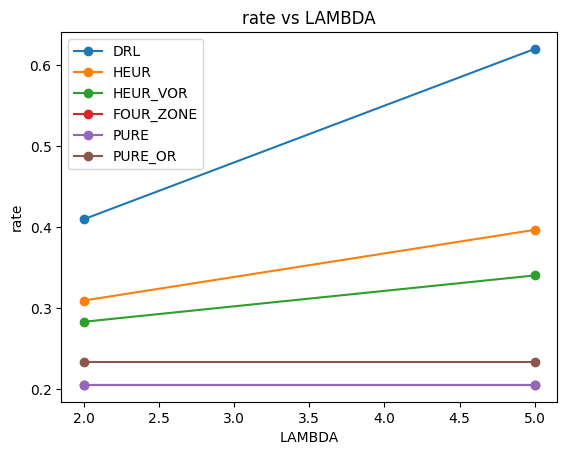

[PLOT] Saved Results/plot_rate_vs_LAMBDA.png


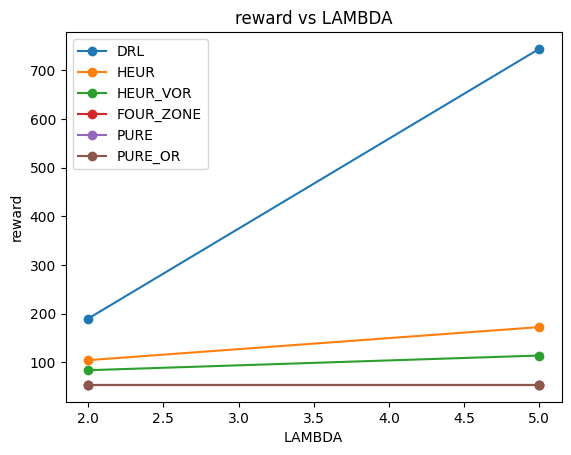

[PLOT] Saved Results/plot_reward_vs_LAMBDA.png


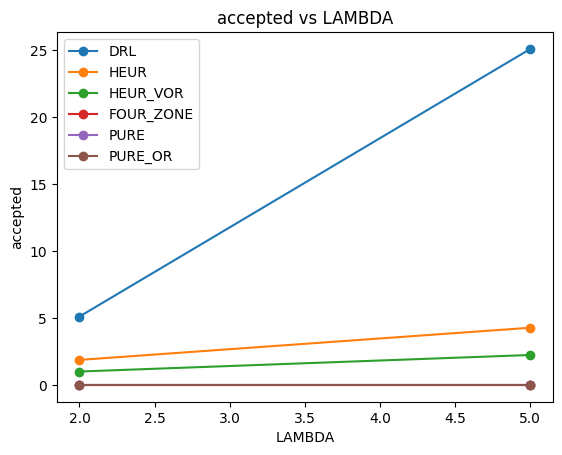

[PLOT] Saved Results/plot_accepted_vs_LAMBDA.png


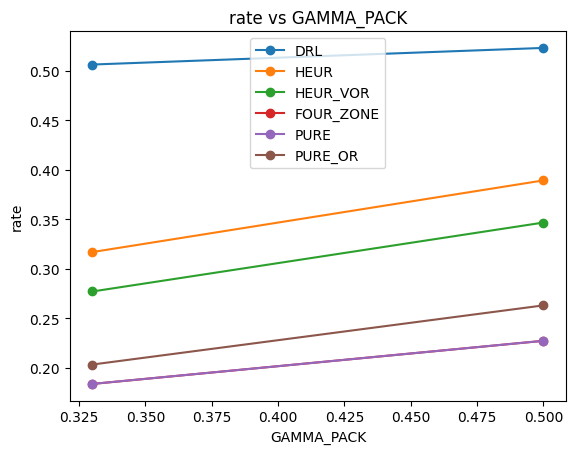

[PLOT] Saved Results/plot_rate_vs_GAMMA_PACK.png


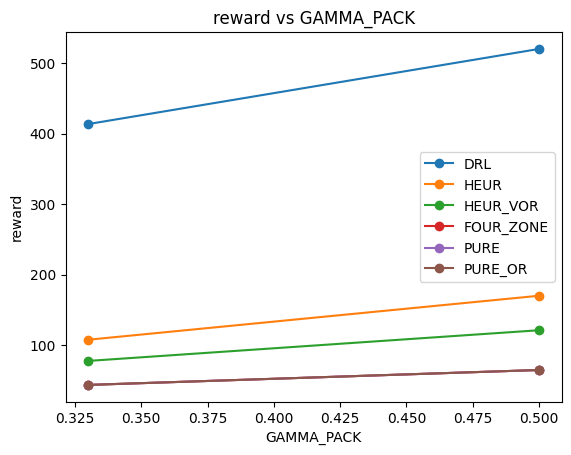

[PLOT] Saved Results/plot_reward_vs_GAMMA_PACK.png


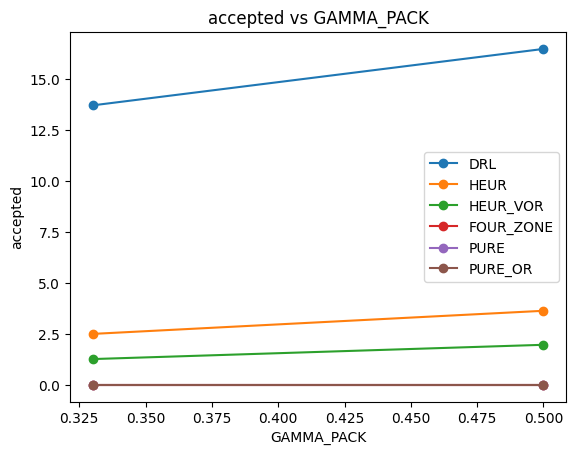

[PLOT] Saved Results/plot_accepted_vs_GAMMA_PACK.png


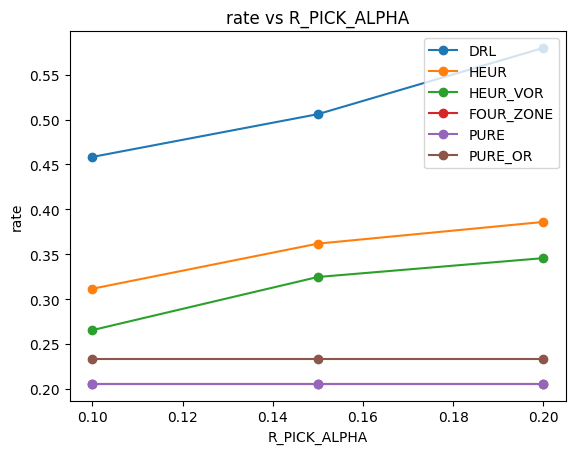

[PLOT] Saved Results/plot_rate_vs_R_PICK_ALPHA.png


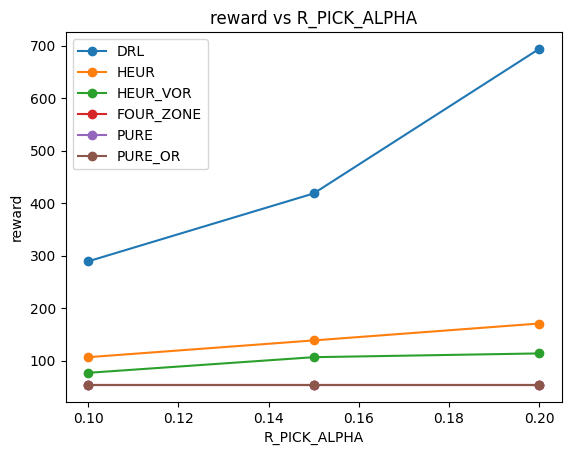

[PLOT] Saved Results/plot_reward_vs_R_PICK_ALPHA.png


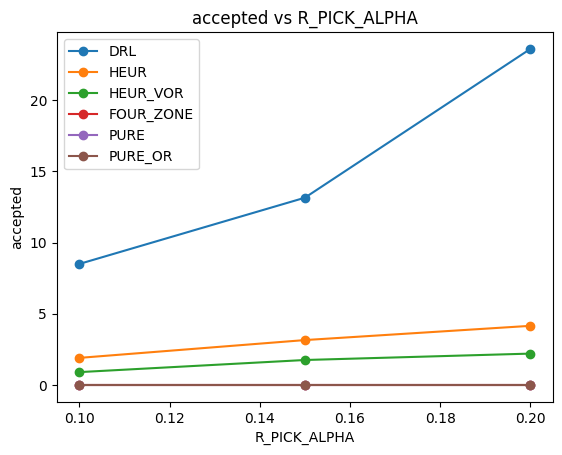

[PLOT] Saved Results/plot_accepted_vs_R_PICK_ALPHA.png


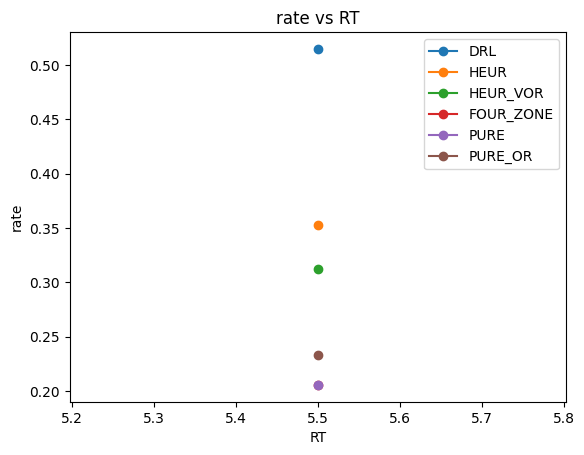

[PLOT] Saved Results/plot_rate_vs_RT.png


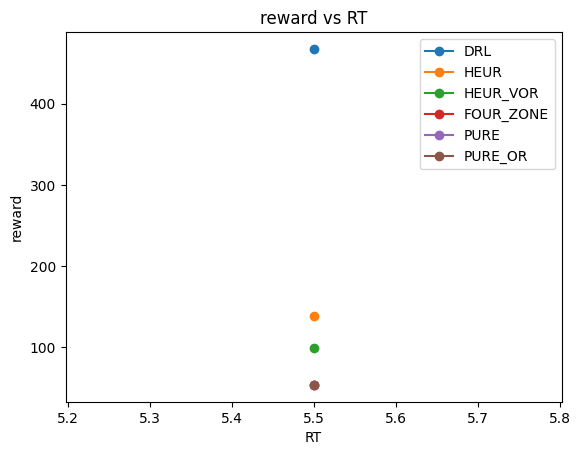

[PLOT] Saved Results/plot_reward_vs_RT.png


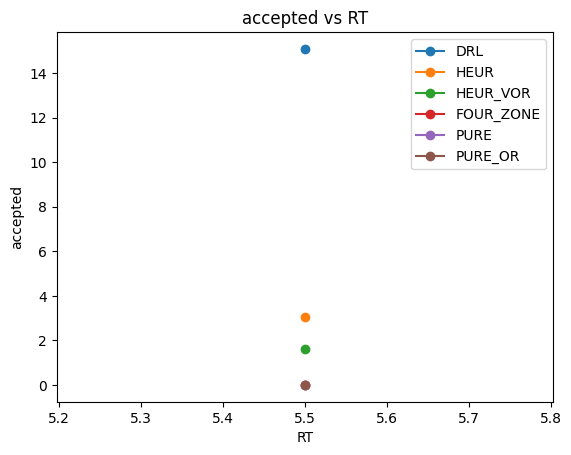

[PLOT] Saved Results/plot_accepted_vs_RT.png


In [34]:
# Plot single-parameter trend graphs (will be saved as PNG)
CSV_PATH = "Results/param_sweep_results_2.csv"
plot_from_csv(CSV_PATH,
              vary_keys=["LAMBDA","GAMMA_PACK","R_PICK_ALPHA",
                         "RT"],
              metrics=("rate", "reward", "accepted"))

/var/folders/w0/y0lmxqzs493g0w6lvk1vbxvm0000gn/T/ipykernel_33373/346774115.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


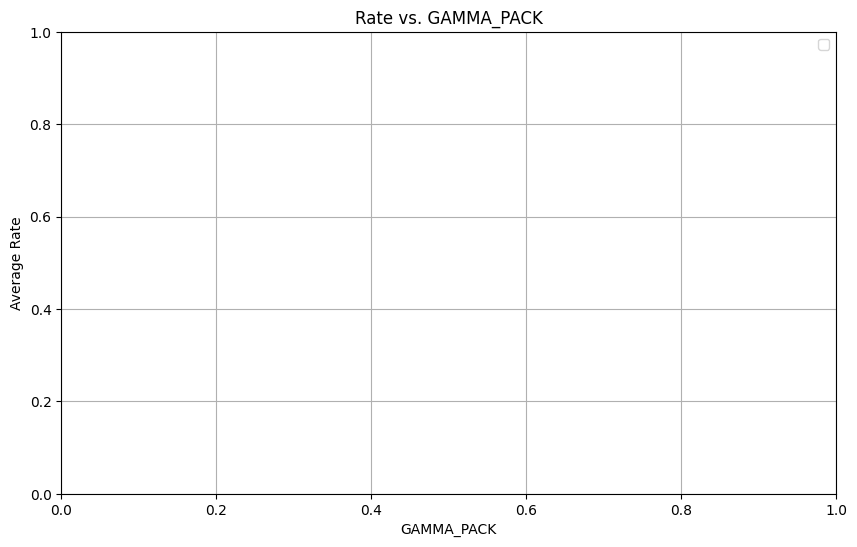

/var/folders/w0/y0lmxqzs493g0w6lvk1vbxvm0000gn/T/ipykernel_33373/346774115.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


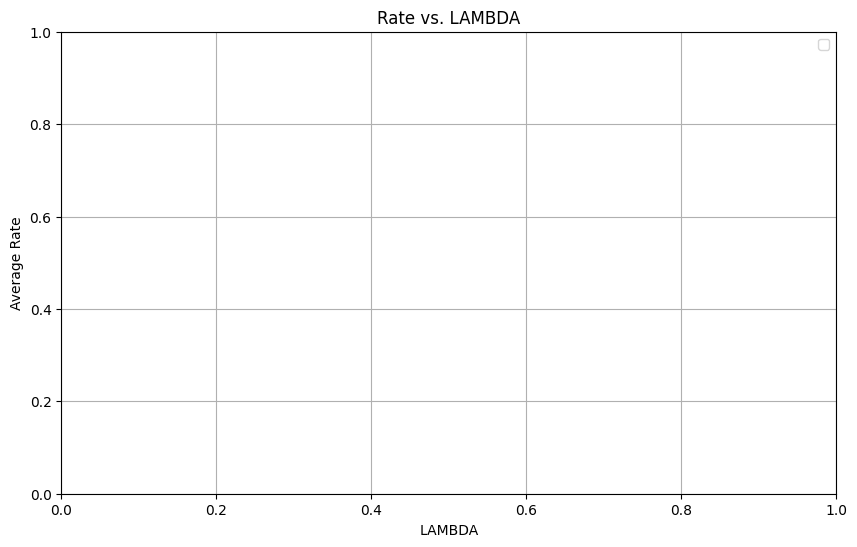

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
csv_path = 'Results/param_sweep_results_2.csv'
df = pd.read_csv(csv_path)

# Filter for RT = 5.5 or 6.0
df_rt2 = df[df['RT'] == 6.0].copy()

# Define the algorithms to plot
algos = ["DRL", "HEUR", "HEUR_VOR", "PURE", "PURE_OR"]

# --- Plot rate vs. GAMMA_PACK ---

# Group by algo and GAMMA_PACK, and calculate the mean rate
pivot_gamma = (df_rt2.groupby(["algo", "GAMMA_PACK"])["rate"]
                     .mean()
                     .reset_index()
                     .pivot(index="GAMMA_PACK", columns="algo", values="rate")
                     .sort_index())

# Plotting
plt.figure(figsize=(10, 6))
for algo in algos:
    if algo in pivot_gamma.columns:
        plt.plot(pivot_gamma.index.values, pivot_gamma[algo].values, marker="o", label=algo)

plt.xlabel("GAMMA_PACK")
plt.ylabel("Average Rate")
plt.title("Rate vs. GAMMA_PACK")
plt.legend()
plt.grid(True)
plt.show()


# --- Plot rate vs. LAMBDA ---

# Group by algo and LAMBDA, and calculate the mean rate
pivot_lambda = (df_rt2.groupby(["algo", "LAMBDA"])["rate"]
                      .mean()
                      .reset_index()
                      .pivot(index="LAMBDA", columns="algo", values="rate")
                      .sort_index())

# Plotting
plt.figure(figsize=(10, 6))
for algo in algos:
    if algo in pivot_lambda.columns:
        plt.plot(pivot_lambda.index.values, pivot_lambda[algo].values, marker="o", label=algo)

plt.xlabel("LAMBDA")
plt.ylabel("Average Rate")
plt.title("Rate vs. LAMBDA")
plt.legend()
plt.grid(True)
plt.show()



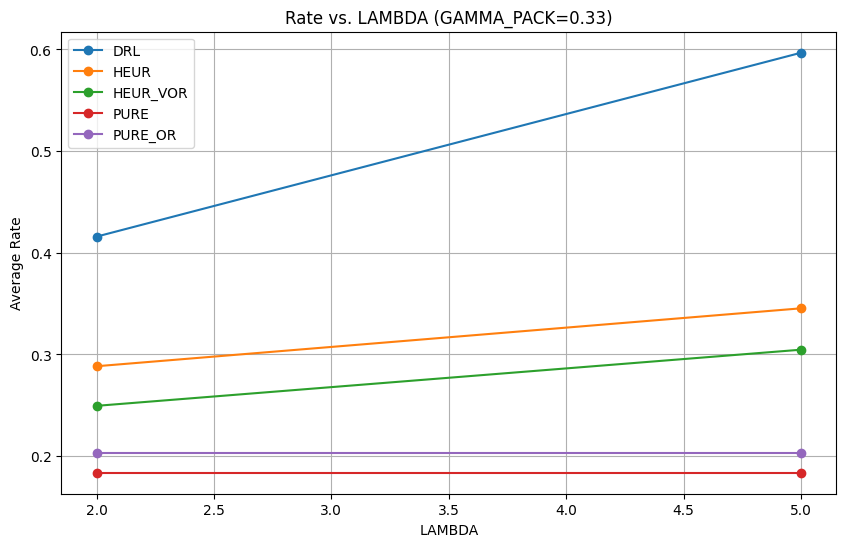

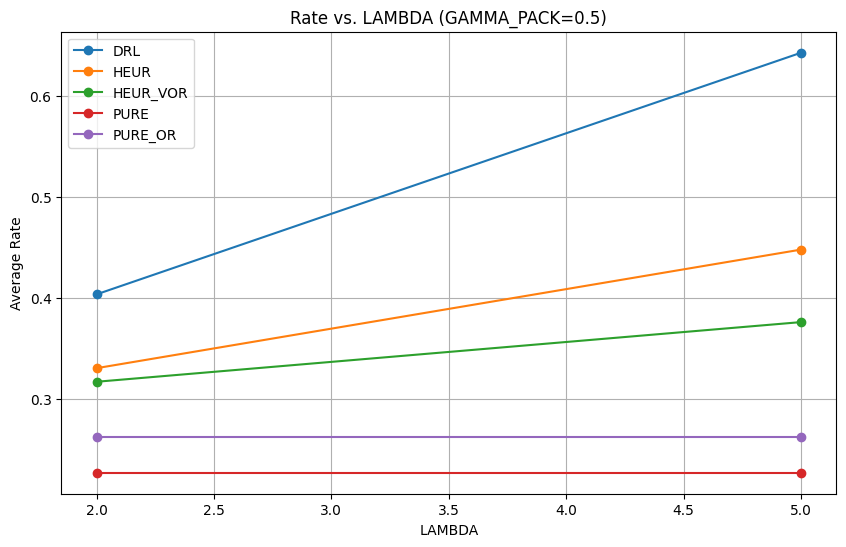

/var/folders/w0/y0lmxqzs493g0w6lvk1vbxvm0000gn/T/ipykernel_33373/2730483407.py:72: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


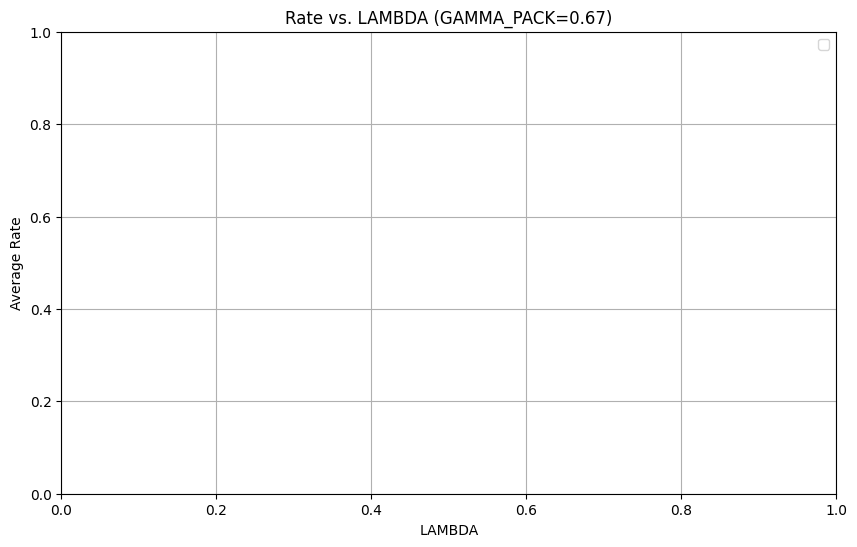

/var/folders/w0/y0lmxqzs493g0w6lvk1vbxvm0000gn/T/ipykernel_33373/2730483407.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


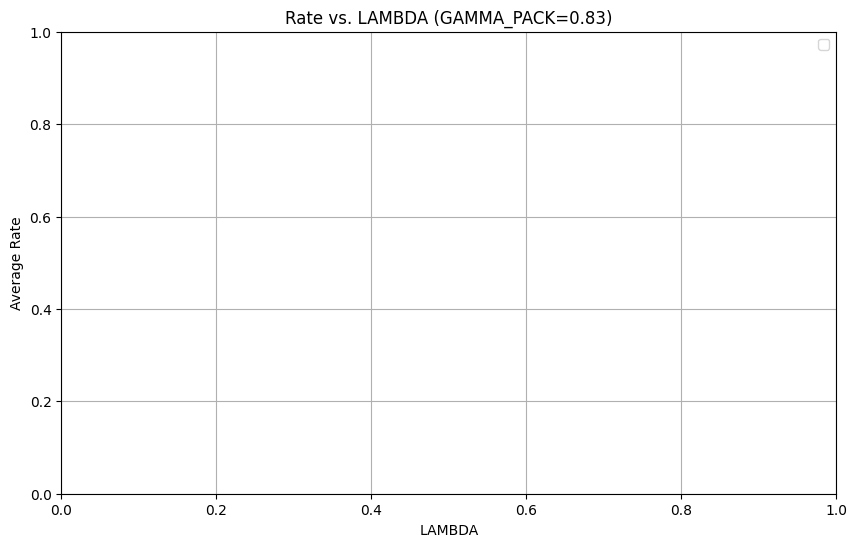

/var/folders/w0/y0lmxqzs493g0w6lvk1vbxvm0000gn/T/ipykernel_33373/2730483407.py:112: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


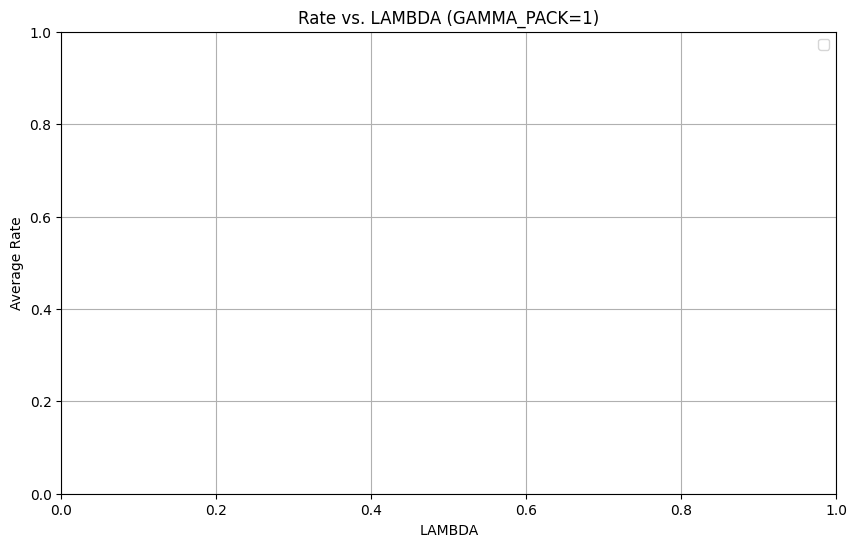

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
csv_path = 'Results/param_sweep_results_2.csv'
df = pd.read_csv(csv_path)


df_rt3 = df[df['GAMMA_PACK'] == 0.33].copy()

# Define the algorithms to plot
algos = ["DRL", "HEUR", "HEUR_VOR", "PURE", "PURE_OR"]
# --- Plot rate vs. LAMBDA ---

# Group by algo and LAMBDA, and calculate the mean rate
pivot_lambda1 = (df_rt3.groupby(["algo", "LAMBDA"])["rate"]
                      .mean()
                      .reset_index()
                      .pivot(index="LAMBDA", columns="algo", values="rate")
                      .sort_index())

# Plotting
plt.figure(figsize=(10, 6))
for algo in algos:
    if algo in pivot_lambda1.columns:
        plt.plot(pivot_lambda1.index.values, pivot_lambda1[algo].values, marker="o", label=algo)

plt.xlabel("LAMBDA")
plt.ylabel("Average Rate")
plt.title("Rate vs. LAMBDA (GAMMA_PACK=0.33)")
plt.legend()
plt.grid(True)
plt.show()

df_rt4 = df[df['GAMMA_PACK'] == 0.5].copy()

pivot_lambda2 = (df_rt4.groupby(["algo", "LAMBDA"])["rate"]
                      .mean()
                      .reset_index()
                      .pivot(index="LAMBDA", columns="algo", values="rate")
                      .sort_index())

plt.figure(figsize=(10, 6))
for algo in algos:
    if algo in pivot_lambda2.columns:
        plt.plot(pivot_lambda2.index.values, pivot_lambda2[algo].values, marker="o", label=algo)

plt.xlabel("LAMBDA")
plt.ylabel("Average Rate")
plt.title("Rate vs. LAMBDA (GAMMA_PACK=0.5)")
plt.legend()
plt.grid(True)
plt.show()

df_rt5 = df[df['GAMMA_PACK'] == 0.67].copy()

pivot_lambda3 = (df_rt5.groupby(["algo", "LAMBDA"])["rate"]
                      .mean()
                      .reset_index()
                      .pivot(index="LAMBDA", columns="algo", values="rate")
                      .sort_index())

plt.figure(figsize=(10, 6))
for algo in algos:
    if algo in pivot_lambda3.columns:
        plt.plot(pivot_lambda3.index.values, pivot_lambda3[algo].values, marker="o", label=algo)

plt.xlabel("LAMBDA")
plt.ylabel("Average Rate")
plt.title("Rate vs. LAMBDA (GAMMA_PACK=0.67)")
plt.legend()
plt.grid(True)
plt.show()

df_rt6 = df[df['GAMMA_PACK'] == 0.83].copy()

pivot_lambda4 = (df_rt6.groupby(["algo", "LAMBDA"])["rate"]
                      .mean()
                      .reset_index()
                      .pivot(index="LAMBDA", columns="algo", values="rate")
                      .sort_index())

plt.figure(figsize=(10, 6))
for algo in algos:
    if algo in pivot_lambda4.columns:
        plt.plot(pivot_lambda4.index.values, pivot_lambda4[algo].values, marker="o", label=algo)

plt.xlabel("LAMBDA")
plt.ylabel("Average Rate")
plt.title("Rate vs. LAMBDA (GAMMA_PACK=0.83)")
plt.legend()
plt.grid(True)
plt.show()

df_rt7 = df[df['GAMMA_PACK'] == 1].copy()

pivot_lambda5 = (df_rt7.groupby(["algo", "LAMBDA"])["rate"]
                      .mean()
                      .reset_index()
                      .pivot(index="LAMBDA", columns="algo", values="rate")
                      .sort_index())

plt.figure(figsize=(10, 6))
for algo in algos:
    if algo in pivot_lambda5.columns:
        plt.plot(pivot_lambda5.index.values, pivot_lambda5[algo].values, marker="o", label=algo)

plt.xlabel("LAMBDA")
plt.ylabel("Average Rate")
plt.title("Rate vs. LAMBDA (GAMMA_PACK=1)")
plt.legend()
plt.grid(True)
plt.show()

Figure saved to plot_rate_vs_lambda_optimal_alpha_gamma_0.33.png


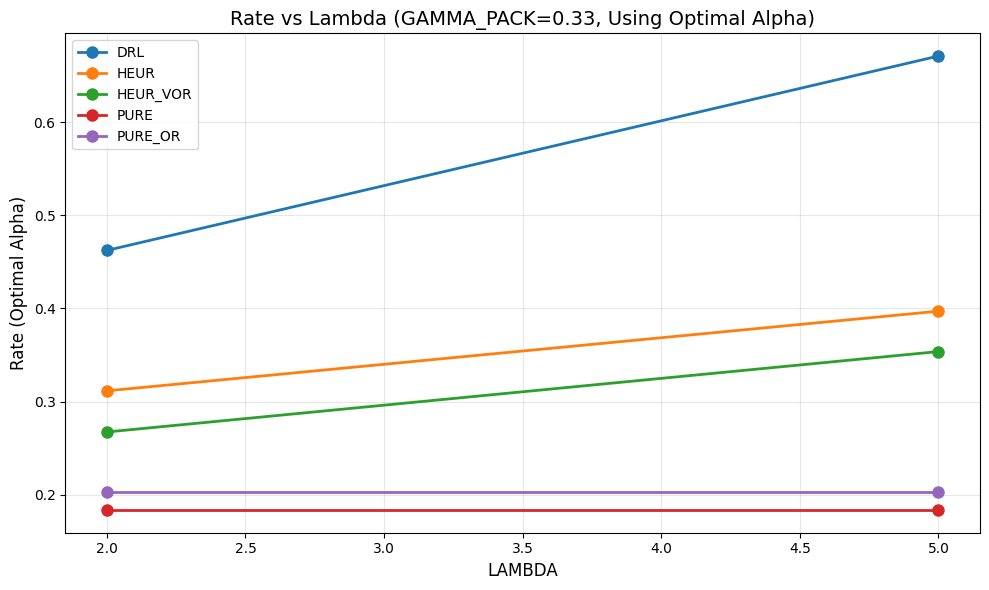

Figure saved to plot_rate_vs_lambda_optimal_alpha_gamma_0.5.png


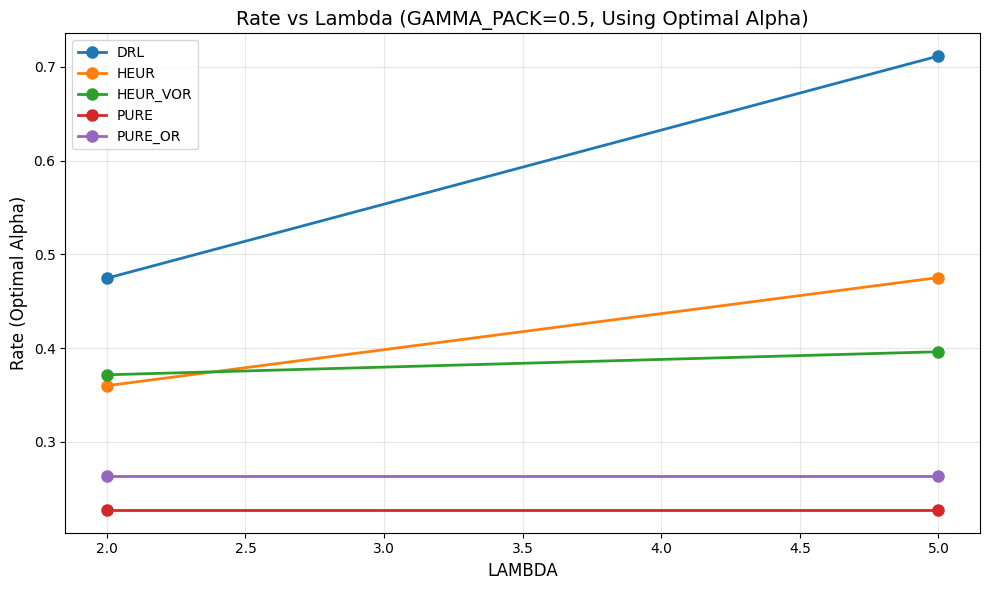

/var/folders/w0/y0lmxqzs493g0w6lvk1vbxvm0000gn/T/ipykernel_33373/4185532911.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


Figure saved to plot_rate_vs_lambda_optimal_alpha_gamma_0.67.png


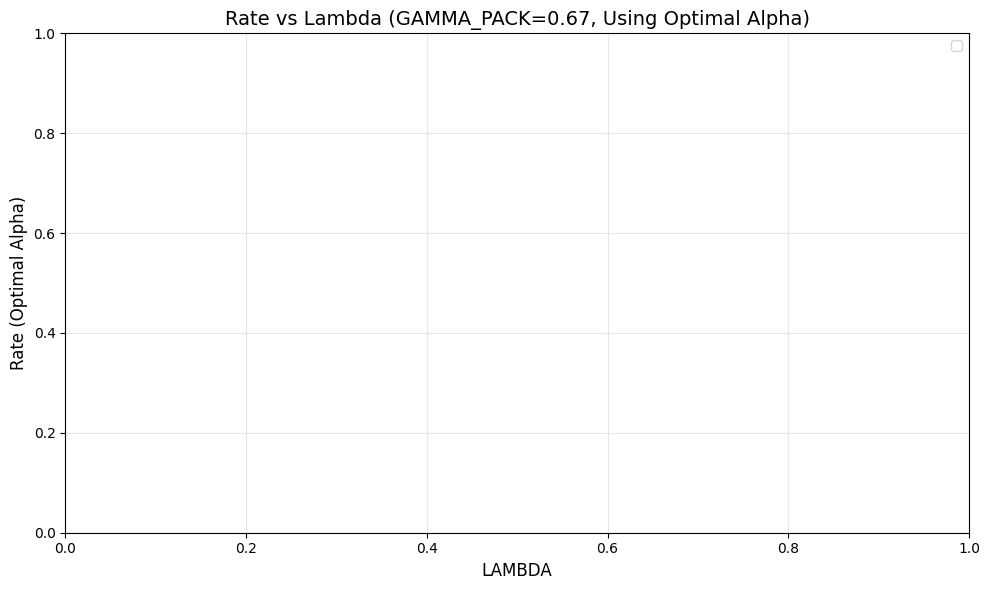

Figure saved to plot_rate_vs_lambda_optimal_alpha_gamma_0.83.png


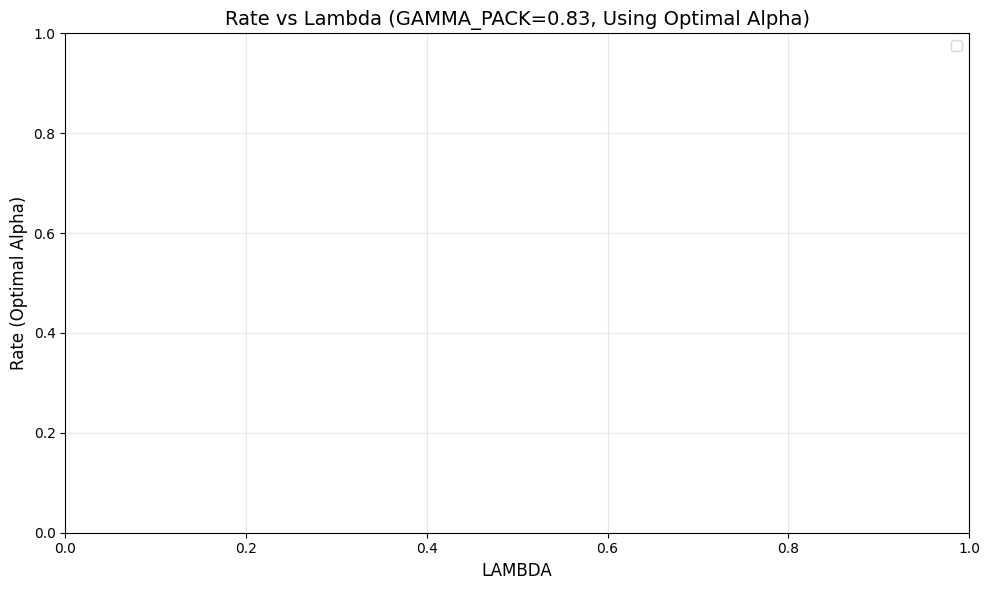

Figure saved to plot_rate_vs_lambda_optimal_alpha_gamma_1.png


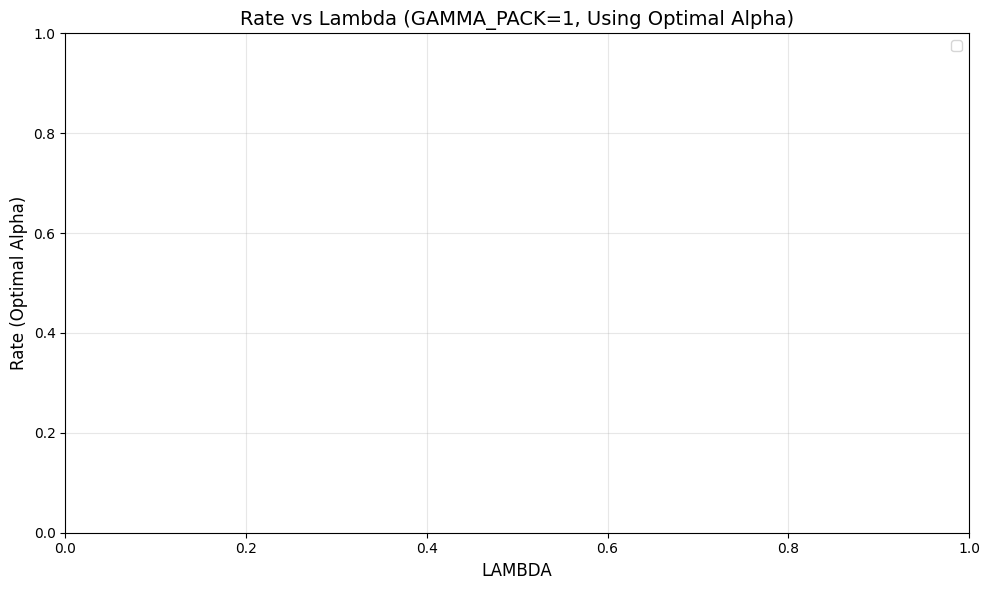

In [37]:
# Optimal Alpha rate and the corresponding rate vs Lambda graph


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional

def plot_rate_vs_lambda_optimal_alpha_by_gamma(csv_path: str,
                                               gamma_values=(0.33, 0.5, 0.67, 0.83, 1),
                                               algos=("DRL", "HEUR", "HEUR_VOR", "PURE"),
                                               savepath_prefix: Optional[str] = None):
    """
    Plot rate vs lambda for each gamma value, where each point for each algorithm 
    corresponds to the rate achieved with the optimal alpha (R_PICK_ALPHA) for that 
    lambda and gamma combination.
    
    For each gamma value:
        For each lambda value and each algorithm:
            1. Filter data for that gamma, lambda, and algorithm
            2. Find the R_PICK_ALPHA that gives the maximum rate (averaged across other parameters)
            3. Use that optimal alpha's rate value as the point for that lambda
    
    Args:
        csv_path: Path to the CSV file containing parameter sweep results
        gamma_values: Tuple of gamma values to plot (default: (0.51, 0.85))
        algos: Tuple of algorithm names to plot
        savepath_prefix: Optional prefix for saving figures (e.g., "plot" will save as "plot_gamma_0.51.png" and "plot_gamma_0.85.png")
    """
    df = pd.read_csv(csv_path)
    
    # Get unique lambda values
    lambda_values = sorted(df['LAMBDA'].unique())
    
    # Generate a plot for each gamma value
    for gamma_val in gamma_values:
        # Prepare data for plotting
        plot_data = {}
        for algo in algos:
            plot_data[algo] = {'lambda': [], 'rate': []}
            
            for lambda_val in lambda_values:
                # Filter data for this gamma, lambda, and algorithm
                filtered = df[(df['GAMMA_PACK'] == gamma_val) & 
                              (df['LAMBDA'] == lambda_val) & 
                              (df['algo'] == algo)]
                
                if len(filtered) > 0:
                    # Find the R_PICK_ALPHA that gives the maximum rate
                    # Group by R_PICK_ALPHA and calculate mean rate, then find the max
                    alpha_rates = filtered.groupby('R_PICK_ALPHA')['rate'].mean()
                    optimal_alpha = alpha_rates.idxmax()
                    optimal_rate = alpha_rates.max()
                    
                    plot_data[algo]['lambda'].append(lambda_val)
                    plot_data[algo]['rate'].append(optimal_rate)
        
        # Plotting
        plt.figure(figsize=(10, 6))
        for algo in algos:
            if len(plot_data[algo]['lambda']) > 0:
                plt.plot(plot_data[algo]['lambda'], plot_data[algo]['rate'], 
                        marker='o', label=algo, linewidth=2, markersize=8)
        
        plt.xlabel('LAMBDA', fontsize=12)
        plt.ylabel('Rate (Optimal Alpha)', fontsize=12)
        plt.title(f'Rate vs Lambda (GAMMA_PACK={gamma_val}, Using Optimal Alpha)', fontsize=14)
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        if savepath_prefix:
            savepath = f"{savepath_prefix}_gamma_{gamma_val}.png"
            plt.savefig(savepath, dpi=300, bbox_inches='tight')
            print(f"Figure saved to {savepath}")
        
        plt.show()

# Example usage
plot_rate_vs_lambda_optimal_alpha_by_gamma(
    csv_path="Results/param_sweep_results_2.csv",
    gamma_values=(0.33, 0.5, 0.67, 0.83, 1),
    algos=("DRL", "HEUR", "HEUR_VOR", "PURE", "PURE_OR"),
    savepath_prefix="plot_rate_vs_lambda_optimal_alpha"
)



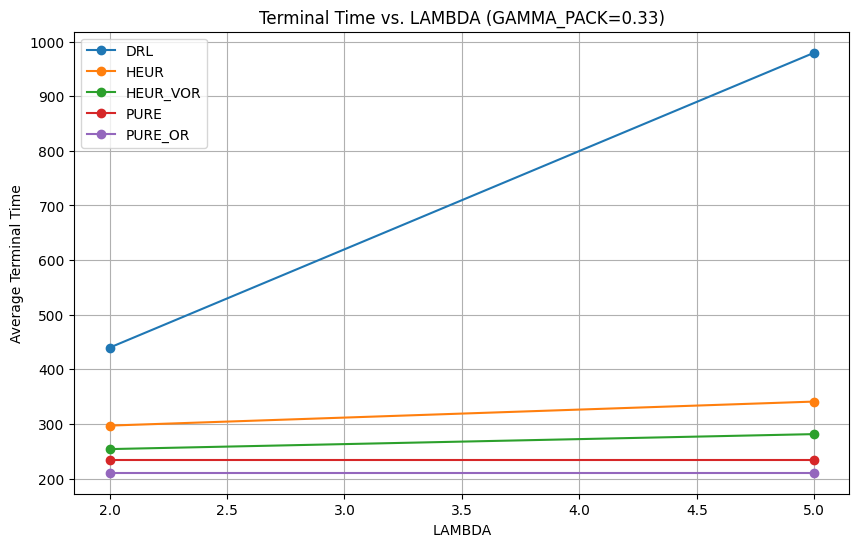

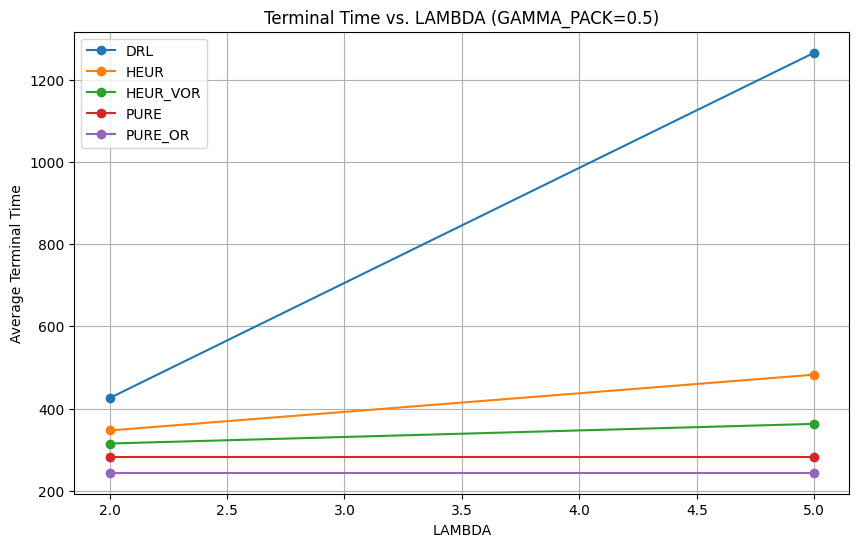

/var/folders/w0/y0lmxqzs493g0w6lvk1vbxvm0000gn/T/ipykernel_33373/2957425170.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


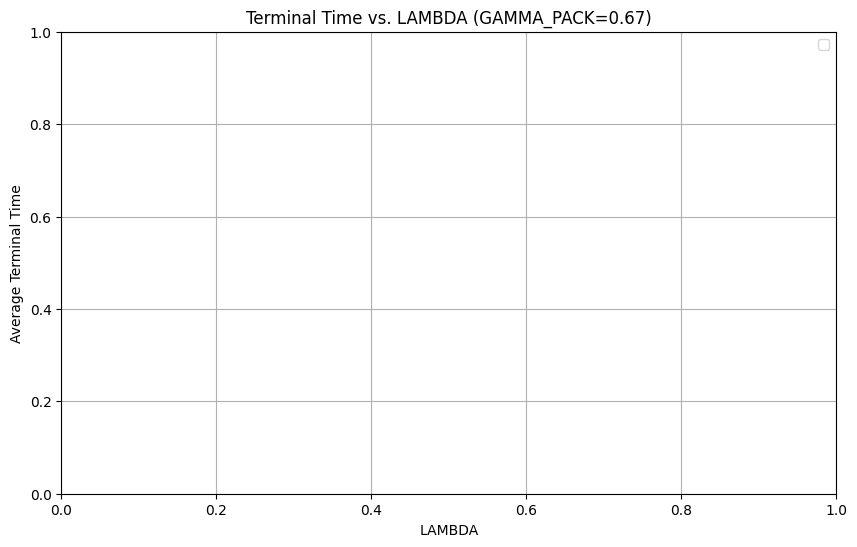

/var/folders/w0/y0lmxqzs493g0w6lvk1vbxvm0000gn/T/ipykernel_33373/2957425170.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


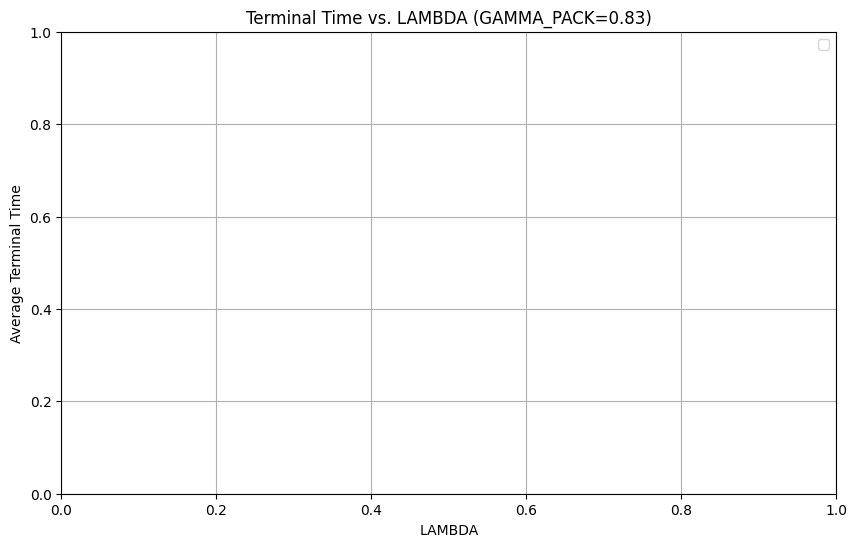

/var/folders/w0/y0lmxqzs493g0w6lvk1vbxvm0000gn/T/ipykernel_33373/2957425170.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


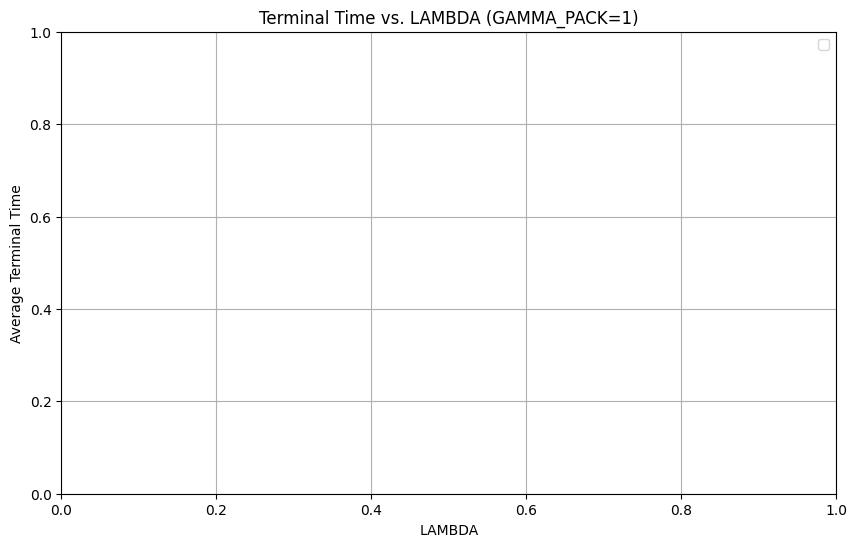

In [38]:
# Average terminal time comparison between algorithms with different lambda and gamma

# Load the dataset
csv_path = 'Results/param_sweep_results_2.csv'
df = pd.read_csv(csv_path)

# Define the algorithms to plot
algos = ["DRL", "HEUR", "HEUR_VOR", "PURE", "PURE_OR"]

# Define gamma values to plot
gamma_values = [0.33, 0.5, 0.67, 0.83, 1]

# Create two separate plots, one for each gamma value
for gamma in gamma_values:
    # Filter data for this gamma value
    df_gamma = df[df['GAMMA_PACK'] == gamma].copy()
    
    # Group by algo and LAMBDA, and calculate the mean terminal_time
    pivot_lambda = (df_gamma.groupby(["algo", "LAMBDA"])["terminal_time"]
                          .mean()
                          .reset_index()
                          .pivot(index="LAMBDA", columns="algo", values="terminal_time")
                          .sort_index())
    
    # Plotting
    plt.figure(figsize=(10, 6))
    for algo in algos:
        if algo in pivot_lambda.columns:
            plt.plot(pivot_lambda.index.values, pivot_lambda[algo].values, marker="o", label=algo)
    
    plt.xlabel("LAMBDA")
    plt.ylabel("Average Terminal Time")
    plt.title(f"Terminal Time vs. LAMBDA (GAMMA_PACK={gamma})")
    plt.legend()
    plt.grid(True)
    plt.show()


In [39]:
# ==============
# Multi-subplot visualization: rate vs GAMMA_PACK for each fixed parameter combination
# ==============
def plot_rate_vs_gamma_by_params(csv_path: str, 
                                  algos=("DRL", "HEUR", "HEUR_VOR", "PURE"),
                                  figsize_per_subplot=(6, 5),
                                  max_subplots_per_row=3,
                                  savepath: Optional[str] = None):
    """
    Create multiple subplots, each showing rate vs GAMMA_PACK for a fixed parameter combination.
    Each subplot only contains data for that specific parameter combination (no cross-combination averaging).
    
    Args:
        csv_path: Path to the CSV file containing parameter sweep results
        algos: Tuple of algorithm names to plot
        figsize_per_subplot: Tuple of (width, height) for each subplot
        max_subplots_per_row: Maximum number of subplots per row
        savepath: Optional path to save the figure
    """
    df = pd.read_csv(csv_path)
    
    # Identify parameter columns (excluding algo, GAMMA_PACK, and metric columns)
    param_cols = ["LAMBDA", "R_PICK_ALPHA", "RIDE_TTL_MIN", "MAX_VISIBLE_RIDES", "SWITCH_GRACE_STEPS", "RT"]
    # Filter to only include columns that exist in the dataframe
    param_cols = [col for col in param_cols if col in df.columns]
    
    # Get unique parameter combinations (excluding GAMMA_PACK)
    param_combos = df[param_cols].drop_duplicates().reset_index(drop=True)
    n_combos = len(param_combos)
    
    if n_combos == 0:
        print("No parameter combinations found. Please check your CSV file.")
        return
    
    # Calculate subplot grid dimensions
    n_rows = (n_combos + max_subplots_per_row - 1) // max_subplots_per_row
    n_cols = min(n_combos, max_subplots_per_row)
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, 
                            figsize=(figsize_per_subplot[0] * n_cols, 
                                    figsize_per_subplot[1] * n_rows))
    
    # Flatten axes array for easier indexing
    if n_combos == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    # Plot each parameter combination
    for idx, (_, combo_row) in enumerate(param_combos.iterrows()):
        ax = axes[idx]
        
        # Filter data for this parameter combination
        mask = True
        for col in param_cols:
            mask = mask & (df[col] == combo_row[col])
        combo_df = df[mask].copy()
        
        # Group by algo and GAMMA_PACK, calculate mean rate
        pivot_data = (combo_df.groupby(["algo", "GAMMA_PACK"])["rate"]
                     .mean()
                     .reset_index()
                     .pivot(index="GAMMA_PACK", columns="algo", values="rate")
                     .sort_index())
        
        # Plot lines for each algorithm
        for algo in algos:
            if algo in pivot_data.columns:
                ax.plot(pivot_data.index.values, pivot_data[algo].values, 
                       marker="o", label=algo, linewidth=2, markersize=6)
        
        # Create multi-line title with parameter values for better readability
        title_parts = []
        for col in param_cols:
            if col in combo_row:
                # Format value based on type (integer vs float)
                val = combo_row[col]
                if isinstance(val, (int, np.integer)) or (isinstance(val, float) and val.is_integer()):
                    title_parts.append(f"{col}={int(val)}")
                else:
                    title_parts.append(f"{col}={val:.2f}")
        
        # Split title into two lines if too many parameters
        if len(title_parts) <= 3:
            title = "\n".join([", ".join(title_parts)])
        else:
            mid = len(title_parts) // 2
            title = "\n".join([", ".join(title_parts[:mid]), ", ".join(title_parts[mid:])])
        
        ax.set_title(title, fontsize=8, pad=10)
        ax.set_xlabel("GAMMA_PACK", fontsize=9)
        ax.set_ylabel("Rate", fontsize=9)
        ax.legend(fontsize=7, loc='best')
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_combos, len(axes)):
        axes[idx].axis('off')
    
    # Adjust layout with more spacing for titles
    plt.tight_layout(pad=2.0, h_pad=1.5, w_pad=1.0)
    
    if savepath:
        plt.savefig(savepath, bbox_inches="tight", dpi=150)
        print(f"[PLOT] Saved {savepath}")
    
    plt.show()



[PLOT] Saved Results/plot_rate_vs_gamma_by_params.png


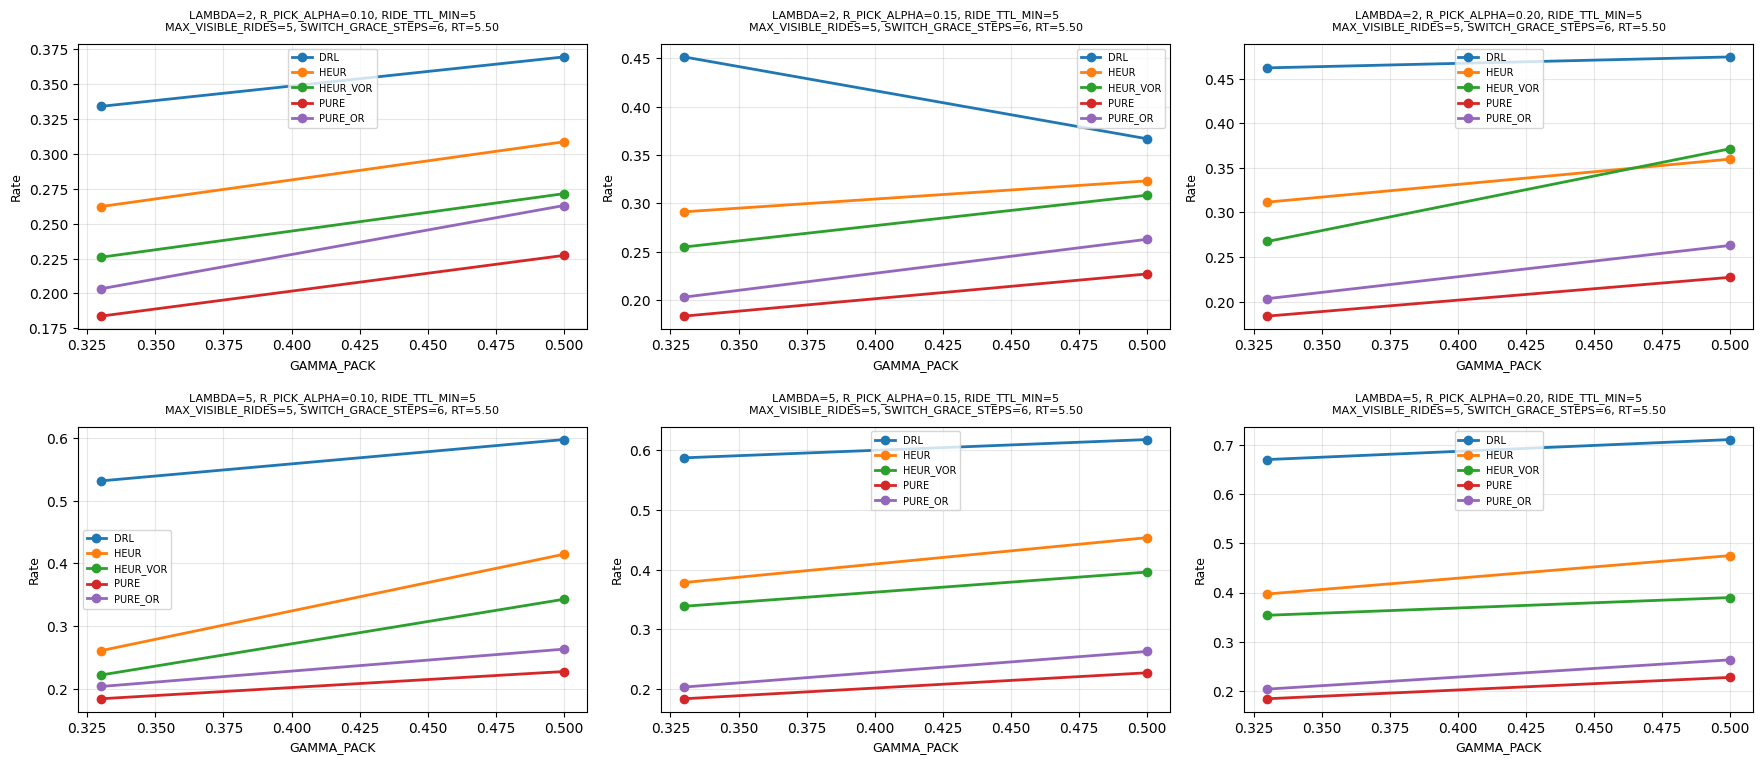

In [40]:
# Example usage: Plot rate vs GAMMA_PACK for each parameter combination
# This will create multiple subplots, one for each unique combination of 
# LAMBDA, R_PICK_ALPHA, RIDE_TTL_MIN, MAX_VISIBLE_RIDES, SWITCH_GRACE_STEPS, RT

plot_rate_vs_gamma_by_params(
    csv_path="Results/param_sweep_results_2.csv",
    algos=("DRL", "HEUR", "HEUR_VOR", "PURE", "PURE_OR"),
    figsize_per_subplot=(6, 4),
    max_subplots_per_row=3,
    savepath="Results/plot_rate_vs_gamma_by_params.png"  # Optional: save the figure
)

